# Normalized

## DSB Normalized protein data B-ALL 

dsb (denoised and scaled by background): a method for normalizing and denoising antibody derived tag data from CITE-seq, ASAP-seq, TEA-seq and related assays.

https://github.com/niaid/dsb

https://www.nature.com/articles/s41467-022-29356-8

#### Two major components of protein expression noise in droplet-based single cell experiments: 
1. protein-specific noise originating from ambient, unbound antibody encapsulated in droplets that can be accurately estimated via the level of “ambi- ent” ADT counts in empty droplets, and 
2. droplet/cell-specific noise revealed via the shared variance component associated with isotype antibody controls and background protein counts in each cell. 

Compared to existing normalization methods, our approach improves downstream analyses by better unmasking biologically meaningful cell populations.

#### Special for protein data:

- noise component of ADT (antibody derived tag) data appears to be added background noise because cells tend to have positive counts for multiple classes of proteins that are reported to be mutually exclusively expressed in distinct cell subsets. 
- current methods/experiments still measure only a small fraction of unique proteins with a wide range of antigen density on different cell types, resulting in individual protein counts in single cells spanning ~2–3 orders of magnitude (e.g., <10 to >1000); differences in total protein counts between cells therefore depend on the specific antibody panel used.
- the total protein counts detected on a given cell may reflect both technical but also biological variations such as cell size across cells and cell types, especially given the dependence of the total ADT counts on the specific antibody panel used.
- Rarely zero counts detected, positive counts even for markers that are not supposed to be expressed in certain cell types => unbound ambient antibodies captured in droplets

####  Solution: 
- Protein specific noise: To remove protein-specific technical noise: transforming counts of each protein in cell-containing droplets by subtracting the mean and dividing by the standard deviation of that same protein across empty droplets. The resulting transformed protein expression values for each cell reflect the number of standard deviations above the expected ambient cap- ture noise, thus centering the negative cell population for each protein around zero to help improve interpretability of the resulting protein expression values 
-  Cell specific noise: isotype control antibodies and the background protein population average in each cell exhibit significant correlations across single cells, we thus use their shared variance to correct for cell-to-cell technical noise in each cell.

#### Isotype control: 
This control checks that the observed staining is not caused by non- specific interactions of the primary antibody. 

In [1]:
import plotly.graph_objs as go
import plotly.offline as py
from matplotlib.path import Path
from ipywidgets import interactive, HBox, VBox
from dash import Dash, dcc, html, Input, Output
from plotly.graph_objs import FigureWidget

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scvi
import scanpy as sc
import umap

from ridgeplot import ridgeplot

sc.set_figure_params(figsize=(8, 8))

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

import warnings

warnings.filterwarnings('ignore')



Global seed set to 0
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning:

pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.

/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning:

The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.



In [2]:
prot_norm = pd.read_csv('/Users/tiinatuononen/Desktop/Project/model_down/data/EG10_norm_prot_exp.csv')

In [3]:
prot_norm.info()

prot_norm_list=prot_norm.columns

prot_norm_list

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6262 entries, 0 to 6261
Data columns (total 34 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  6262 non-null   object 
 1   CD19        6262 non-null   float64
 2   CD10        6262 non-null   float64
 3   CD20        6262 non-null   float64
 4   CD3         6262 non-null   float64
 5   CD2         6262 non-null   float64
 6   CD11b       6262 non-null   float64
 7   HLADR       6262 non-null   float64
 8   CD38        6262 non-null   float64
 9   CD11c       6262 non-null   float64
 10  CD7         6262 non-null   float64
 11  CD45        6262 non-null   float64
 12  CD33        6262 non-null   float64
 13  CD81        6262 non-null   float64
 14  CD73        6262 non-null   float64
 15  CD123       6262 non-null   float64
 16  CD14        6262 non-null   float64
 17  CD45RA      6262 non-null   float64
 18  CD45RO      6262 non-null   float64
 19  CD4         6262 non-null  

Index(['Unnamed: 0', 'CD19', 'CD10', 'CD20', 'CD3', 'CD2', 'CD11b', 'HLADR',
       'CD38', 'CD11c', 'CD7', 'CD45', 'CD33', 'CD81', 'CD73', 'CD123', 'CD14',
       'CD45RA', 'CD45RO', 'CD4', 'CD8a', 'CD197', 'CD127', 'CD56', 'CD5',
       'CD15', 'CD64', 'CD117', 'CD24', 'CD44', 'CD58', 'CD66ace', 'CD13',
       'CD34'],
      dtype='object')

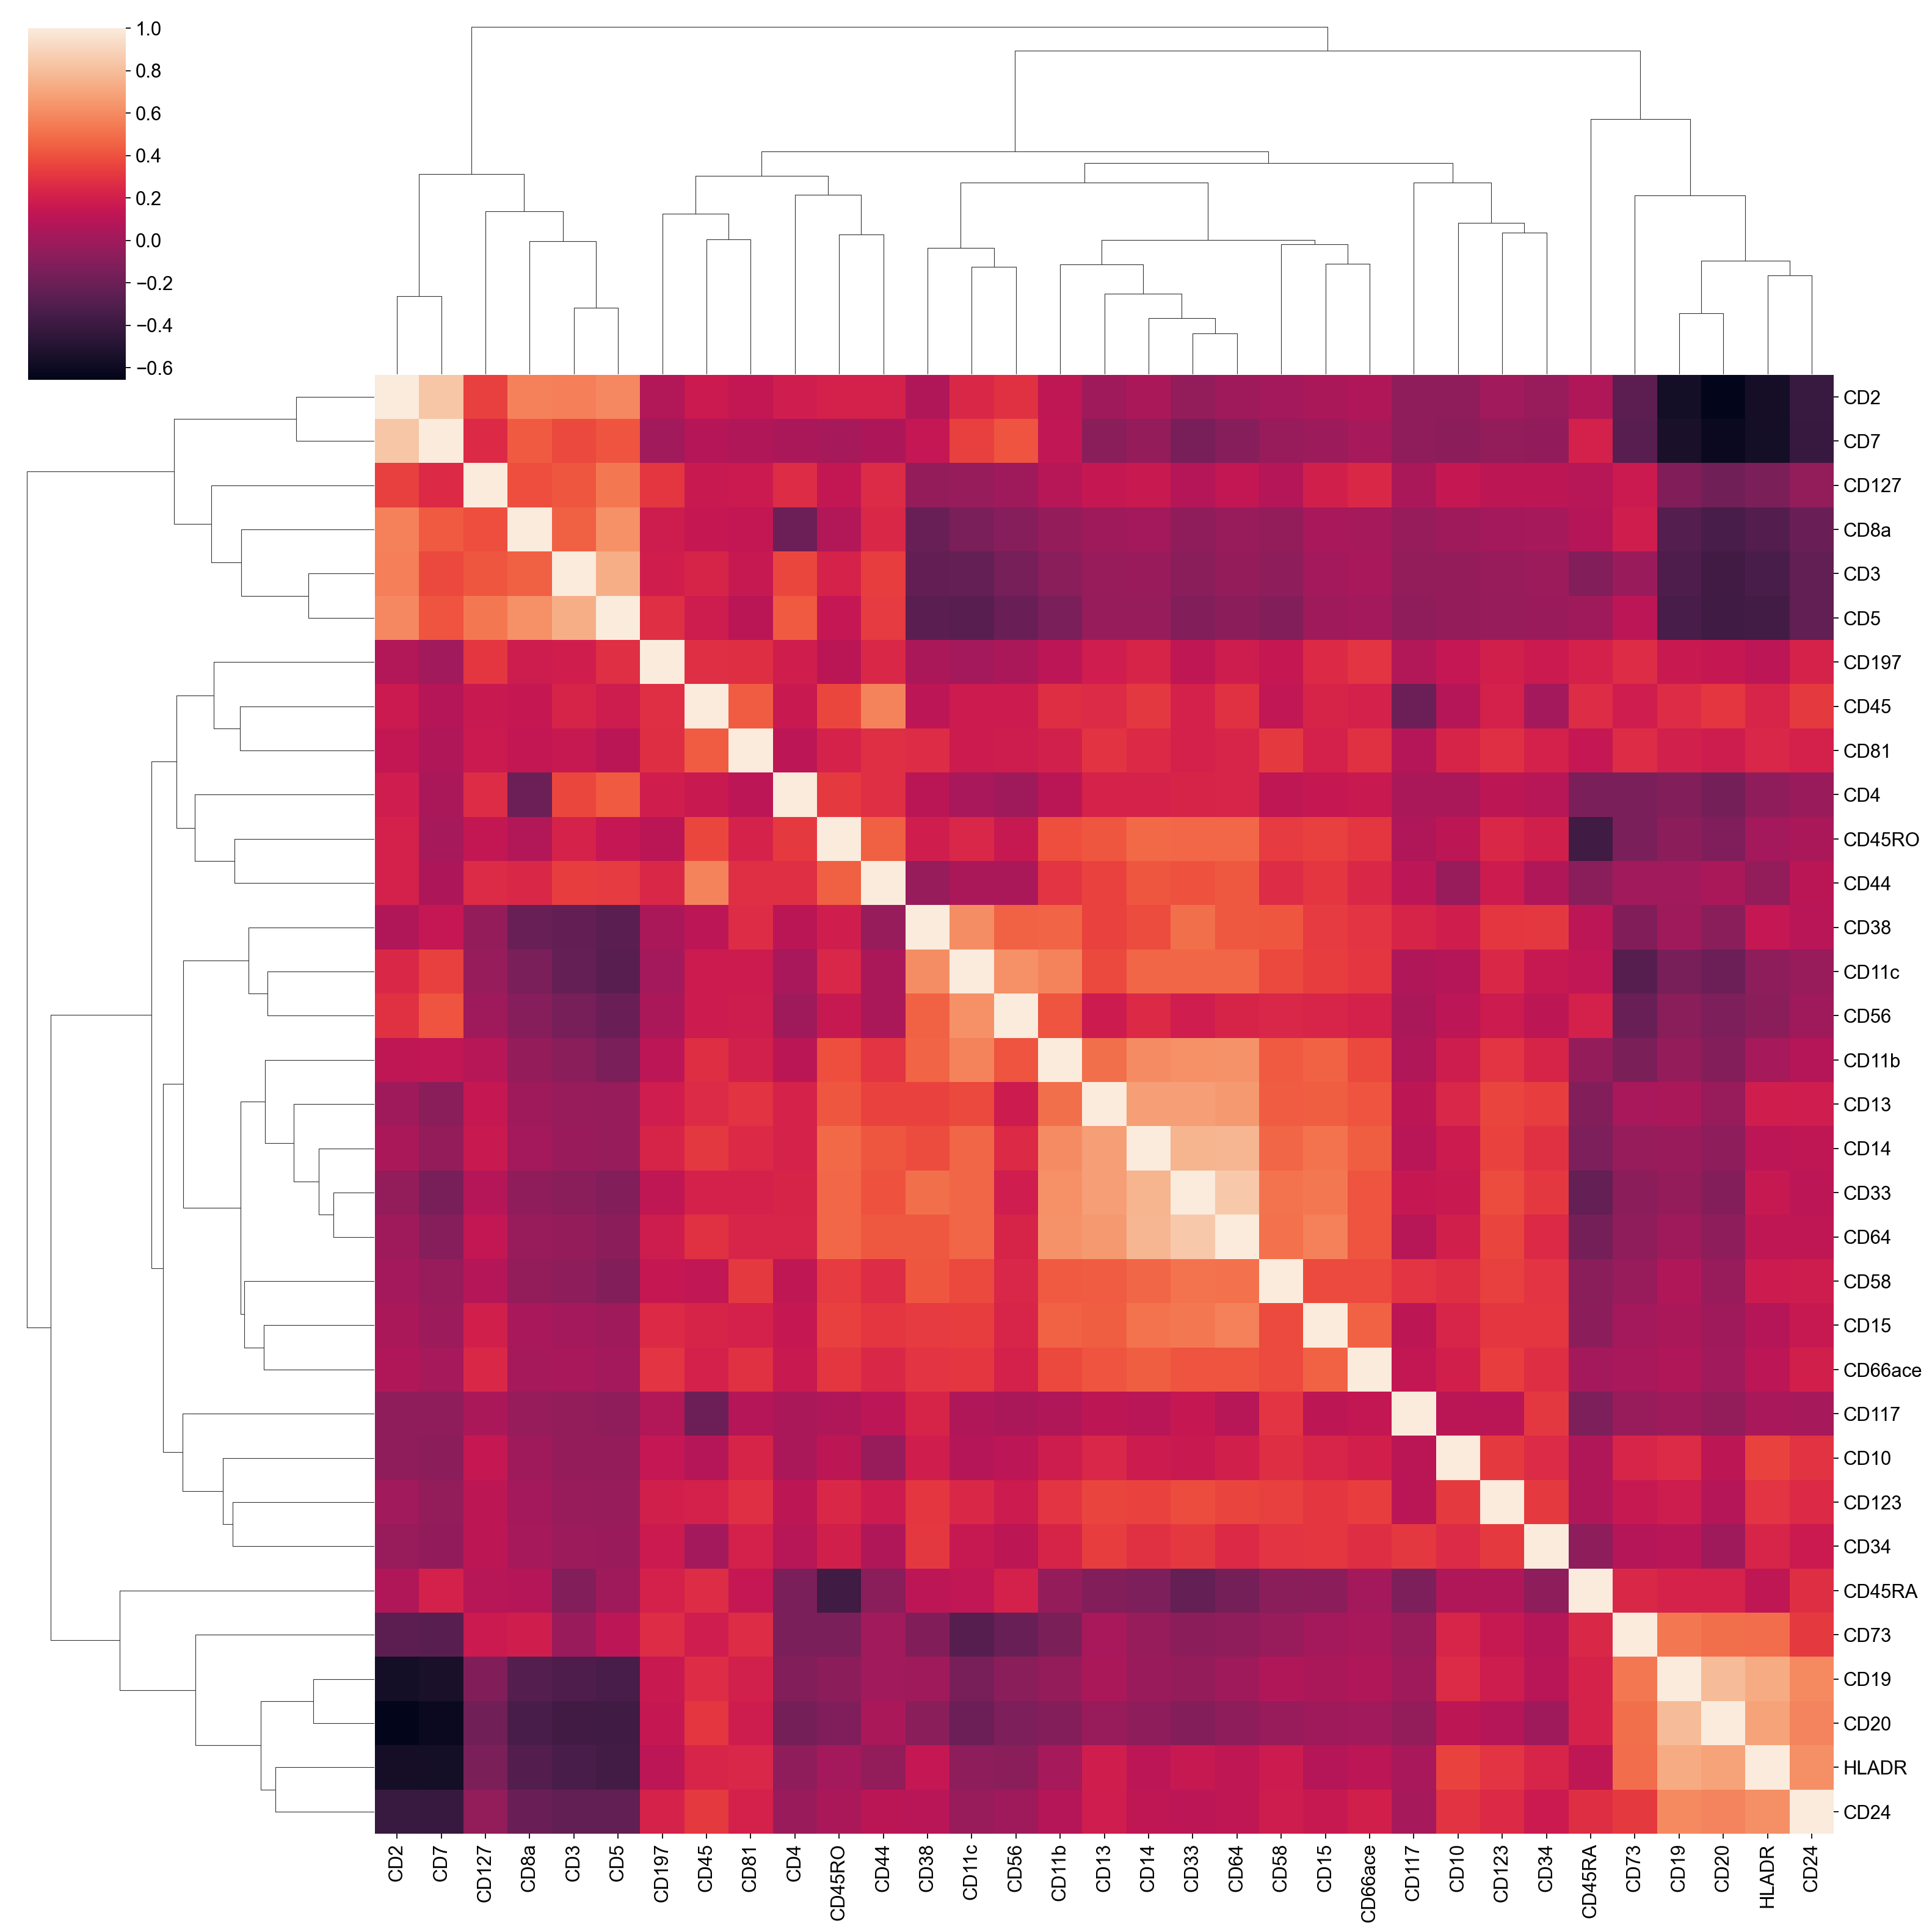

In [4]:
matrix_prot=prot_norm.corr(method='pearson', min_periods=1)
sns.clustermap(matrix_prot, figsize=(20,20))

In [12]:
#sorting by mean

index_sort = prot_norm.mean().sort_values().index
df_sorted = prot_norm[index_sort]

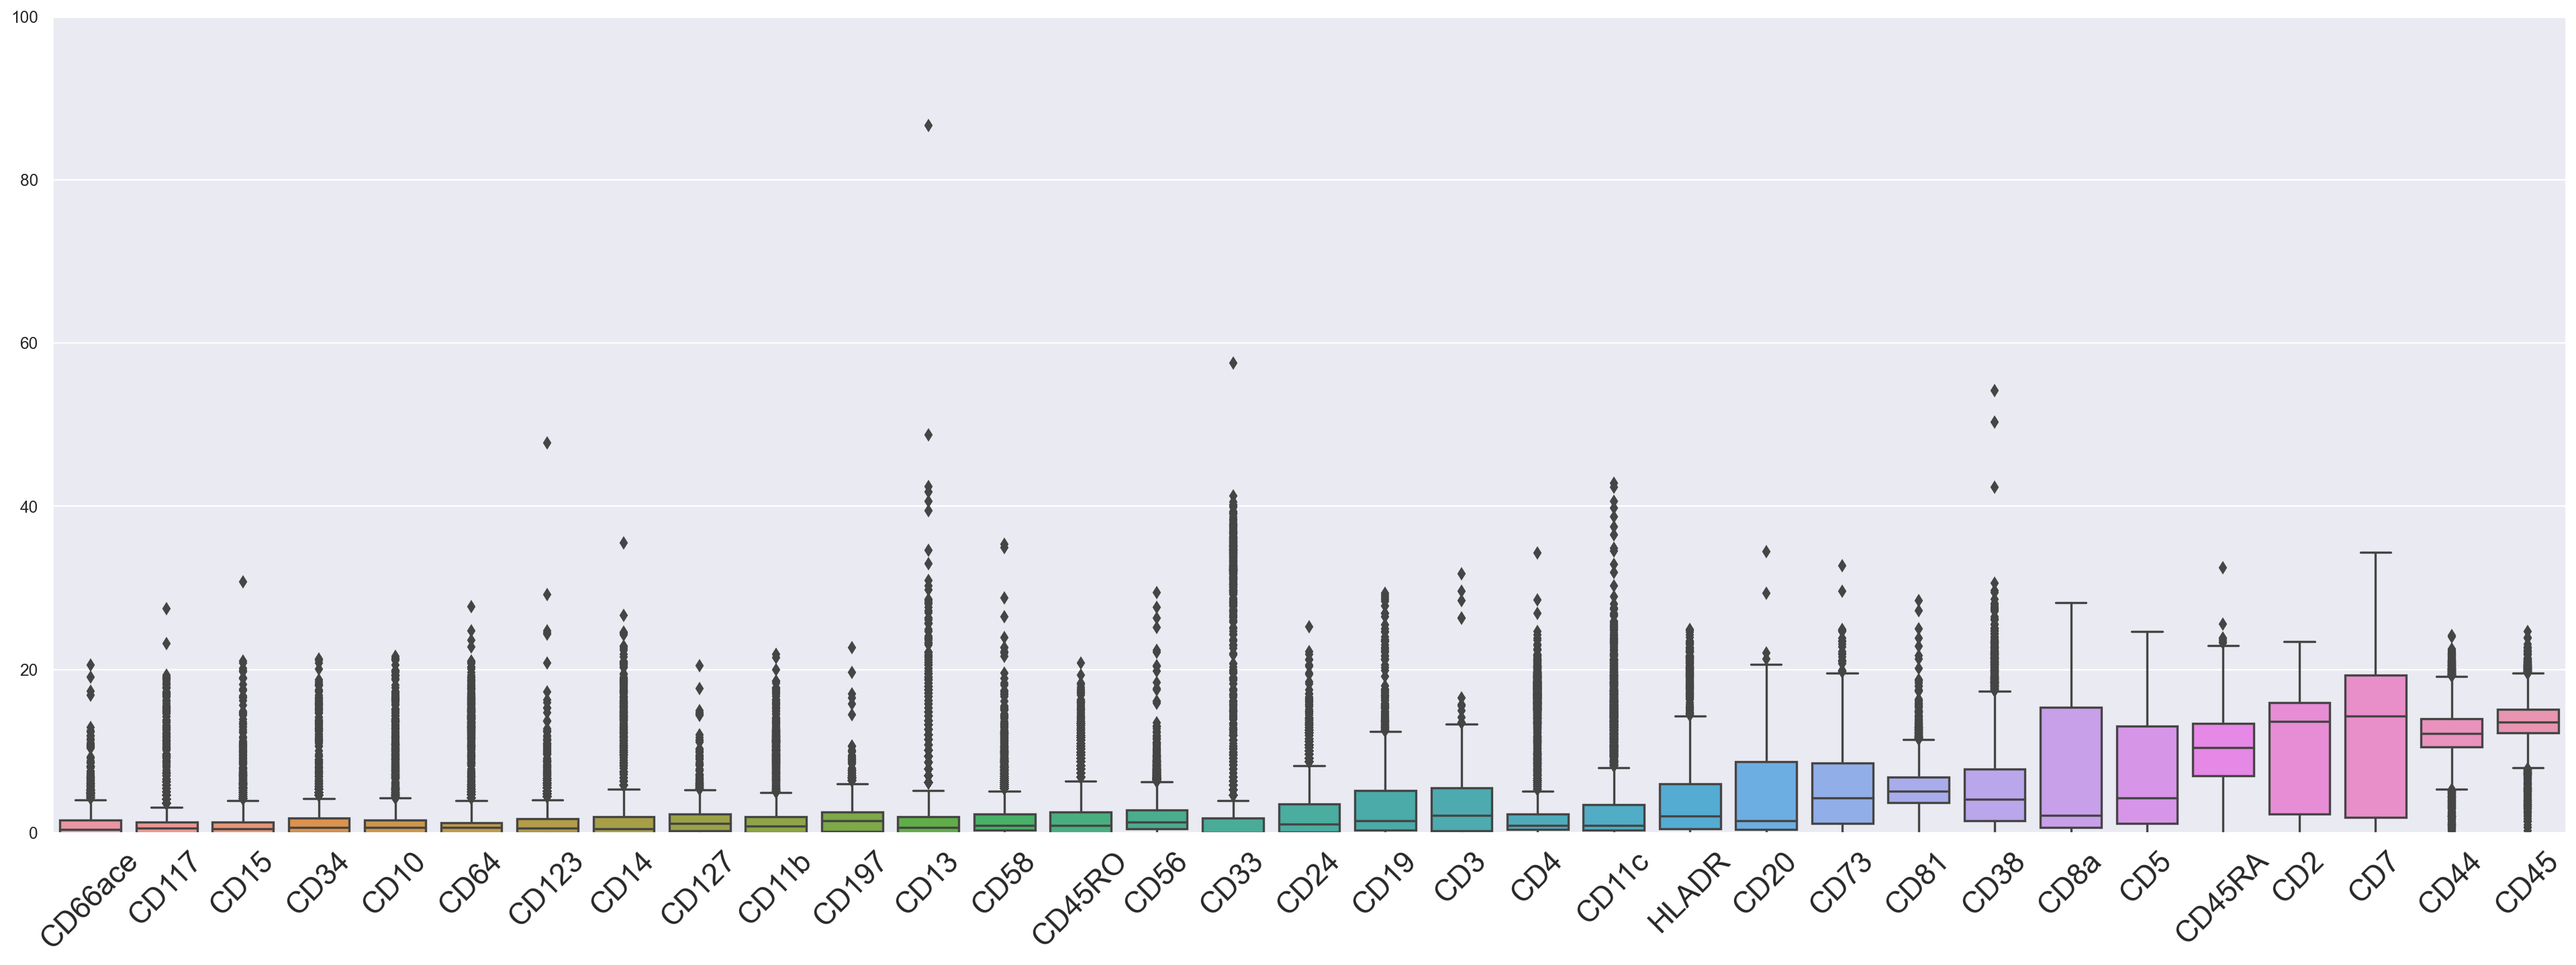

In [18]:
plt.figure(figsize=(30,10))
plt.ylim(0, 100)
d=sns.boxplot(data=df_sorted)

d.set_xticklabels(d.get_xticklabels(),rotation=45) #rotation

d.tick_params(axis='x', labelsize=20) #increased font

<AxesSubplot: xlabel='CD56', ylabel='Density'>

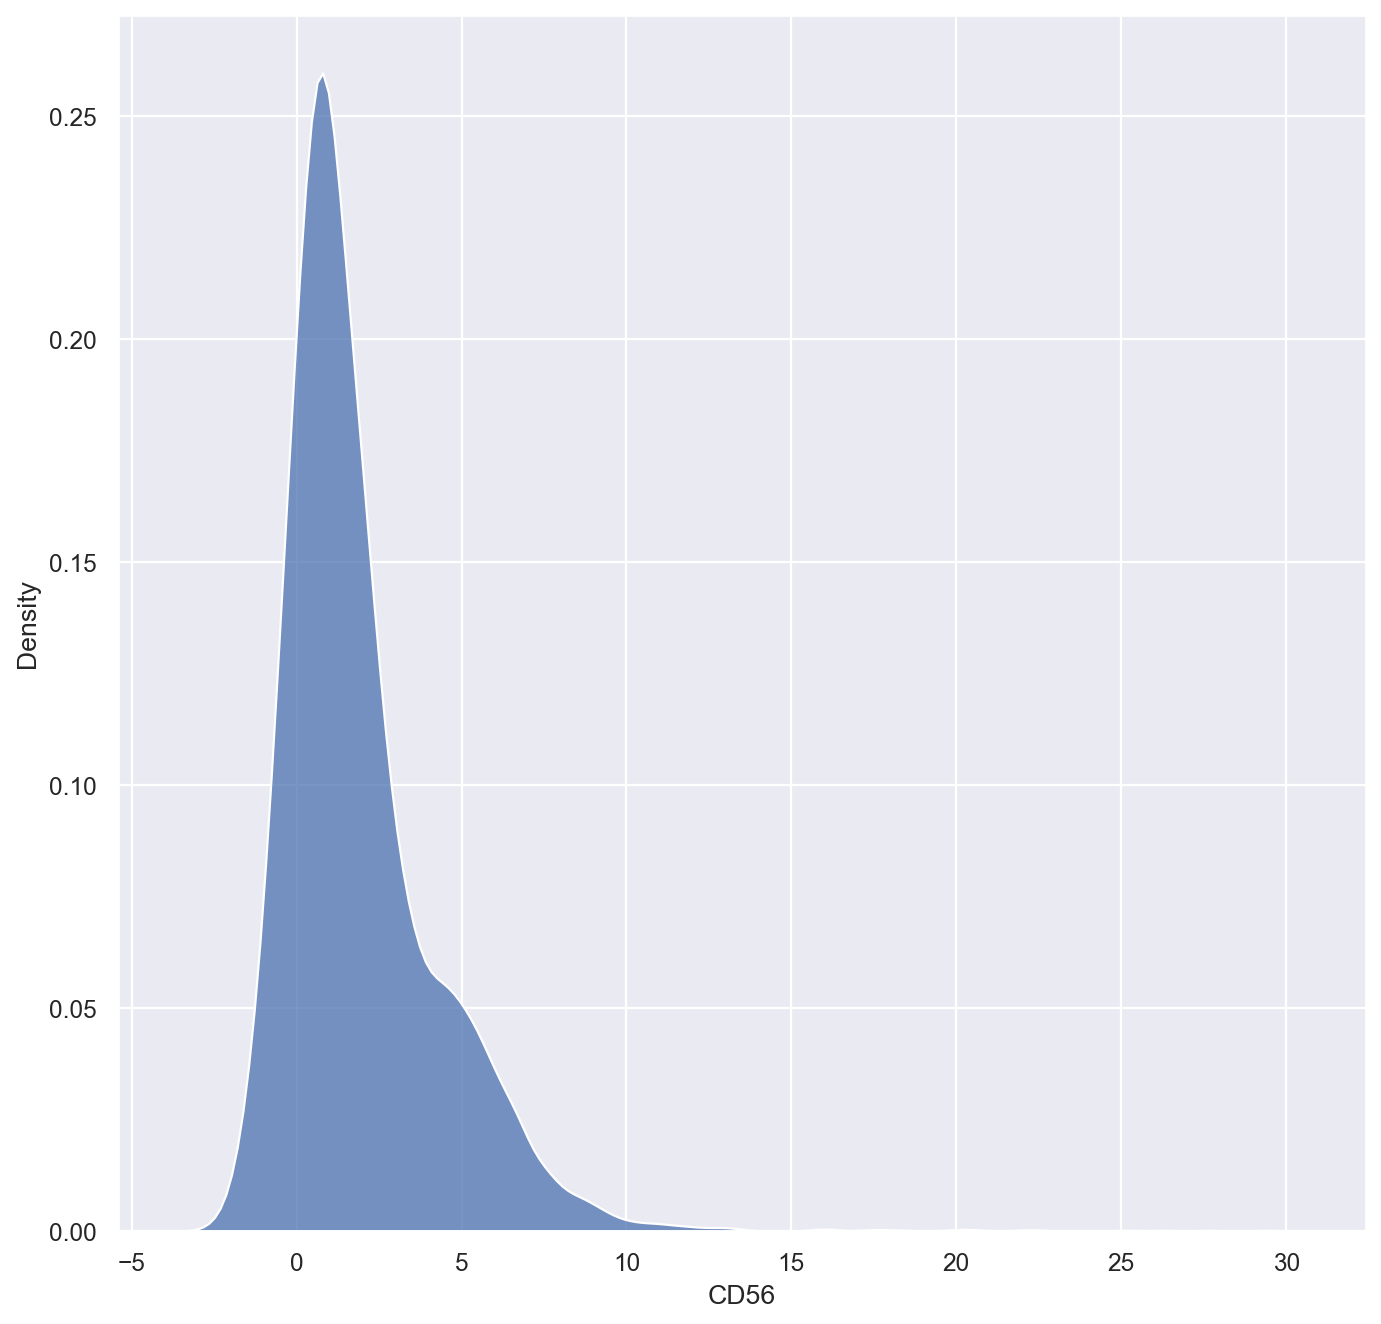

In [19]:
sns.kdeplot(data=prot_norm, x="CD56", multiple="stack")

<AxesSubplot: xlabel='CD56', ylabel='Count'>

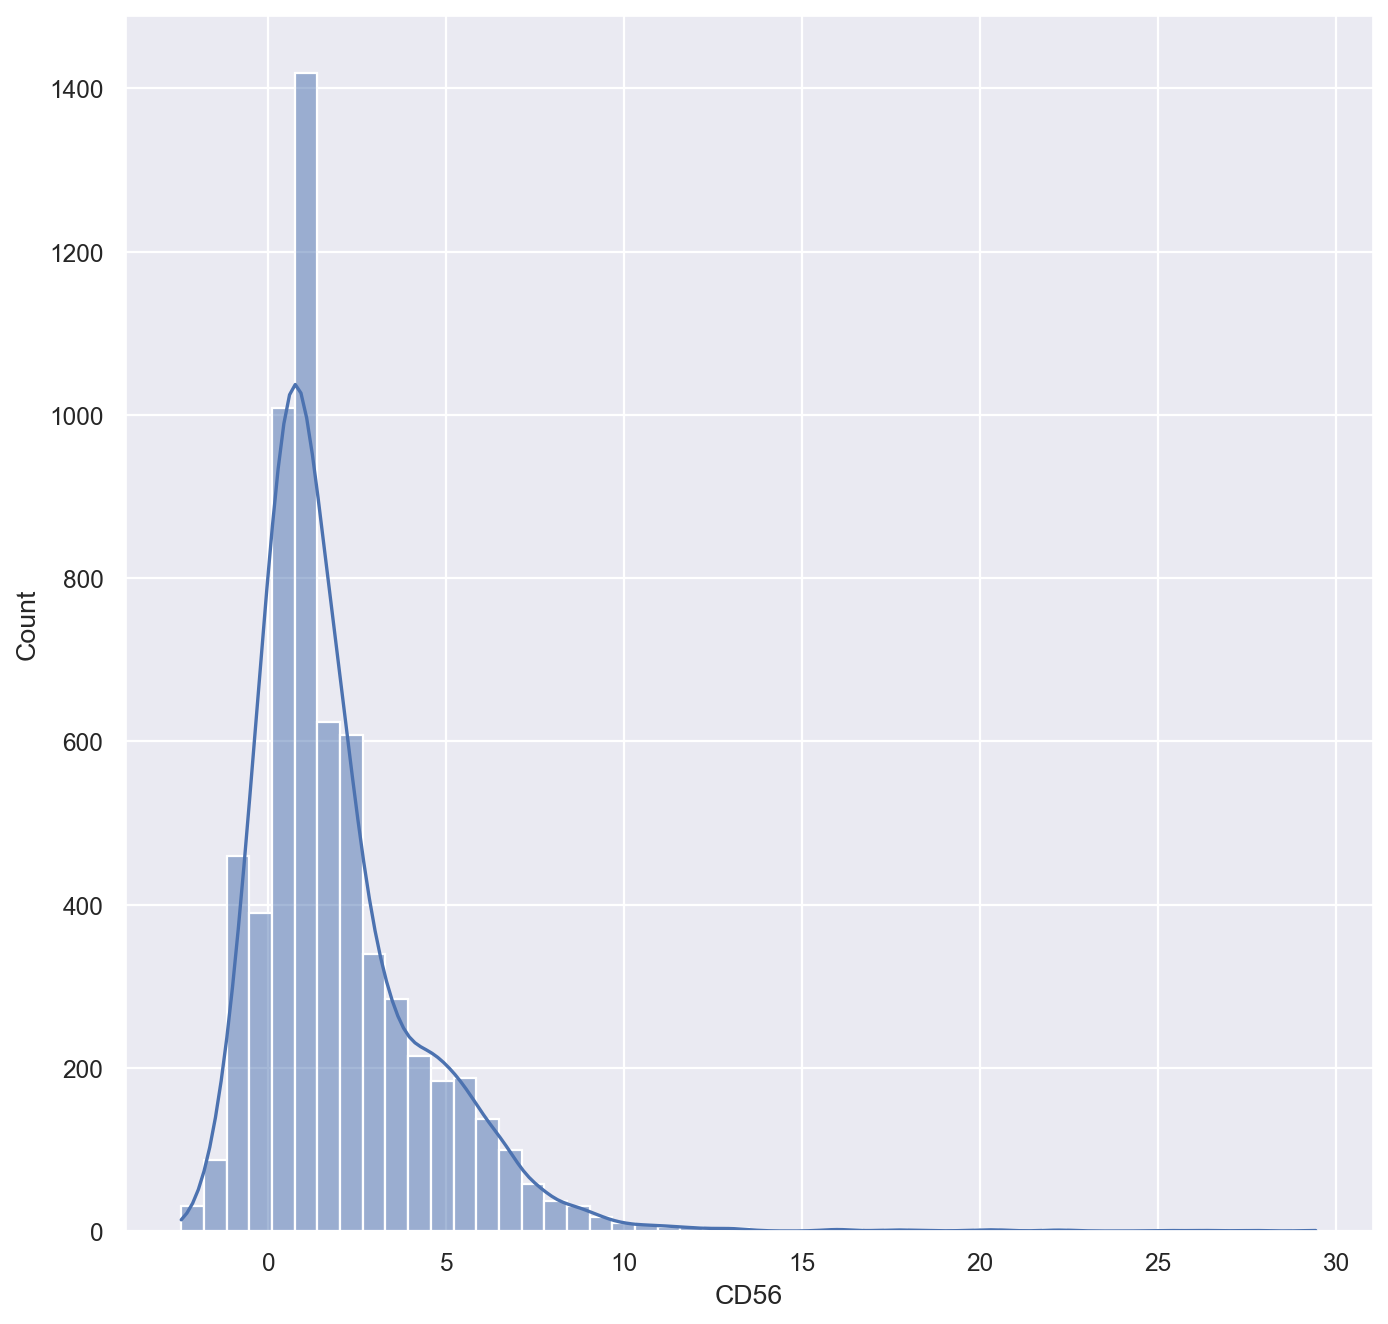

In [20]:
sns.histplot(data=prot_norm, x="CD56", bins = 50, kde=True)

<Figure size 800x800 with 0 Axes>

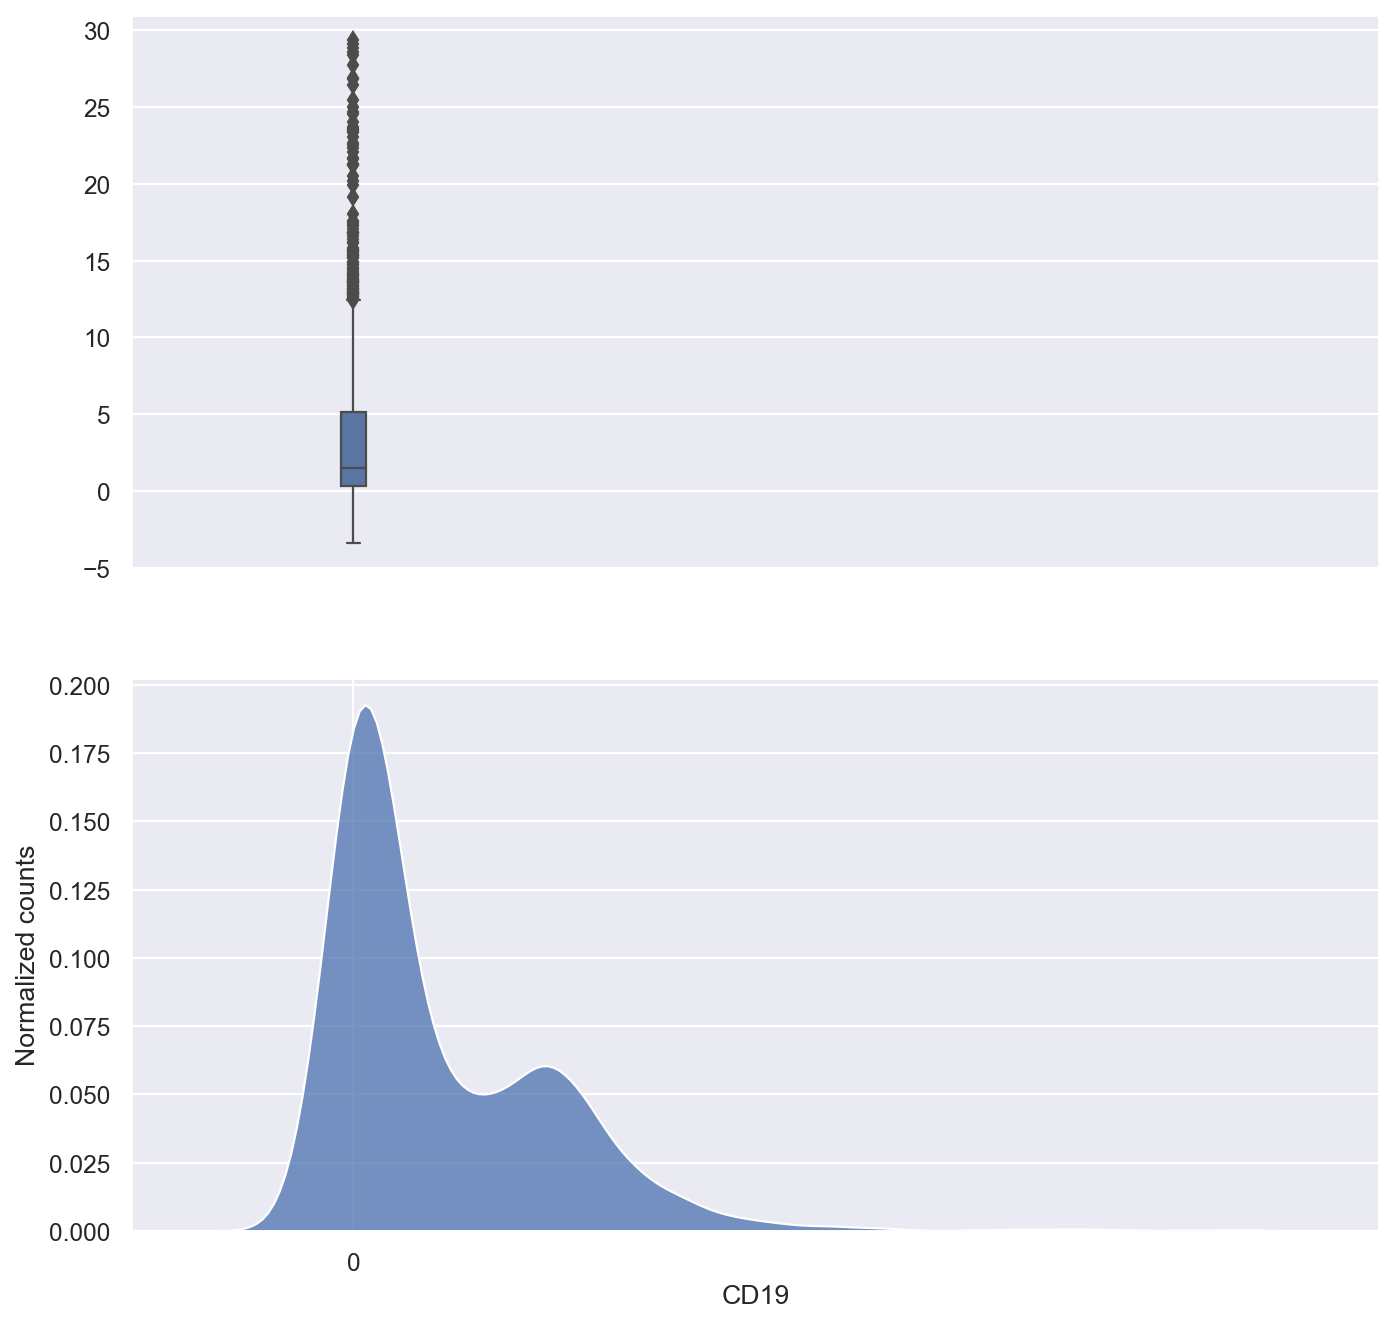

<Figure size 800x800 with 0 Axes>

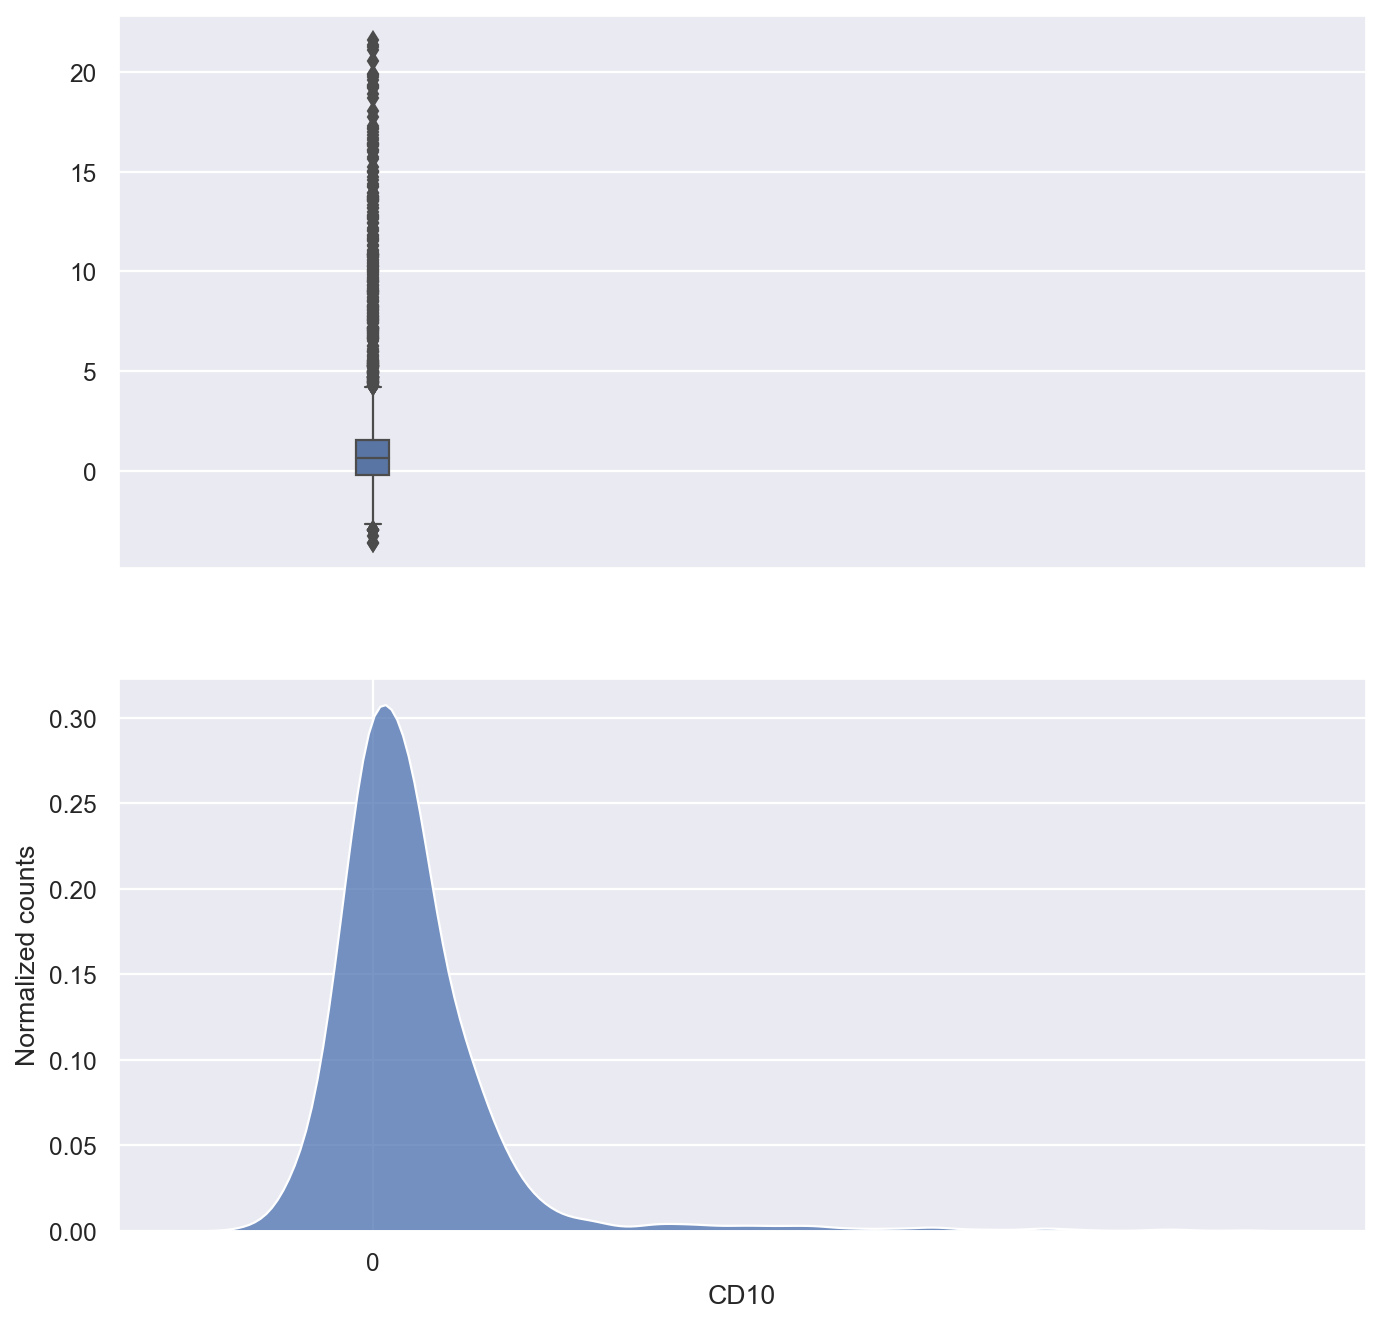

In [21]:
for i in prot_norm.columns[1:3]:
    plt.figure()
    plt.tight_layout()
    sns.set(rc={"figure.figsize":(10, 10)})
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True)
    plt.gca().set(xlabel= i,ylabel='Normalized counts')
    sns.boxplot(prot_norm[i], ax=ax_box , linewidth= 1.0)
    sns.kdeplot(prot_norm[i], ax=ax_hist, multiple="stack")

In [22]:
prot_norm_list=prot_norm.columns
prot_norm_list

Index(['Unnamed: 0', 'CD19', 'CD10', 'CD20', 'CD3', 'CD2', 'CD11b', 'HLADR',
       'CD38', 'CD11c', 'CD7', 'CD45', 'CD33', 'CD81', 'CD73', 'CD123', 'CD14',
       'CD45RA', 'CD45RO', 'CD4', 'CD8a', 'CD197', 'CD127', 'CD56', 'CD5',
       'CD15', 'CD64', 'CD117', 'CD24', 'CD44', 'CD58', 'CD66ace', 'CD13',
       'CD34'],
      dtype='object')

## CLR normalized protein data B-ALL 

The original developers of CITE-seq normalized ADT data by using a centered log ratio transformation (CLR). 

Relative to total surface proteins of a cell (across proteins) OR relative to a other cells (across cells). However, not taking into account the specific technical noise of protein data. 

The CLR transformation helps to better separate cell populations, but it does not directly estimate and correct for specific sources of technical noise including the apparent background noise mentioned earlier. 



In [23]:
prot_CLR_norm = pd.read_csv('/Users/tiinatuononen/Desktop/Project/model_down/data/norm_prot_exp_clr.csv')

In [24]:
prot_CLR_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6262 entries, 0 to 6261
Data columns (total 34 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  6262 non-null   object 
 1   CD19        6262 non-null   float64
 2   CD10        6262 non-null   float64
 3   CD20        6262 non-null   float64
 4   CD3         6262 non-null   float64
 5   CD2         6262 non-null   float64
 6   CD11b       6262 non-null   float64
 7   HLADR       6262 non-null   float64
 8   CD38        6262 non-null   float64
 9   CD11c       6262 non-null   float64
 10  CD7         6262 non-null   float64
 11  CD45        6262 non-null   float64
 12  CD33        6262 non-null   float64
 13  CD81        6262 non-null   float64
 14  CD73        6262 non-null   float64
 15  CD123       6262 non-null   float64
 16  CD14        6262 non-null   float64
 17  CD45RA      6262 non-null   float64
 18  CD45RO      6262 non-null   float64
 19  CD4         6262 non-null  

In [25]:
#sorting by mean

index_sort = prot_CLR_norm.mean().sort_values().index
df_sorted2 = prot_CLR_norm[index_sort]

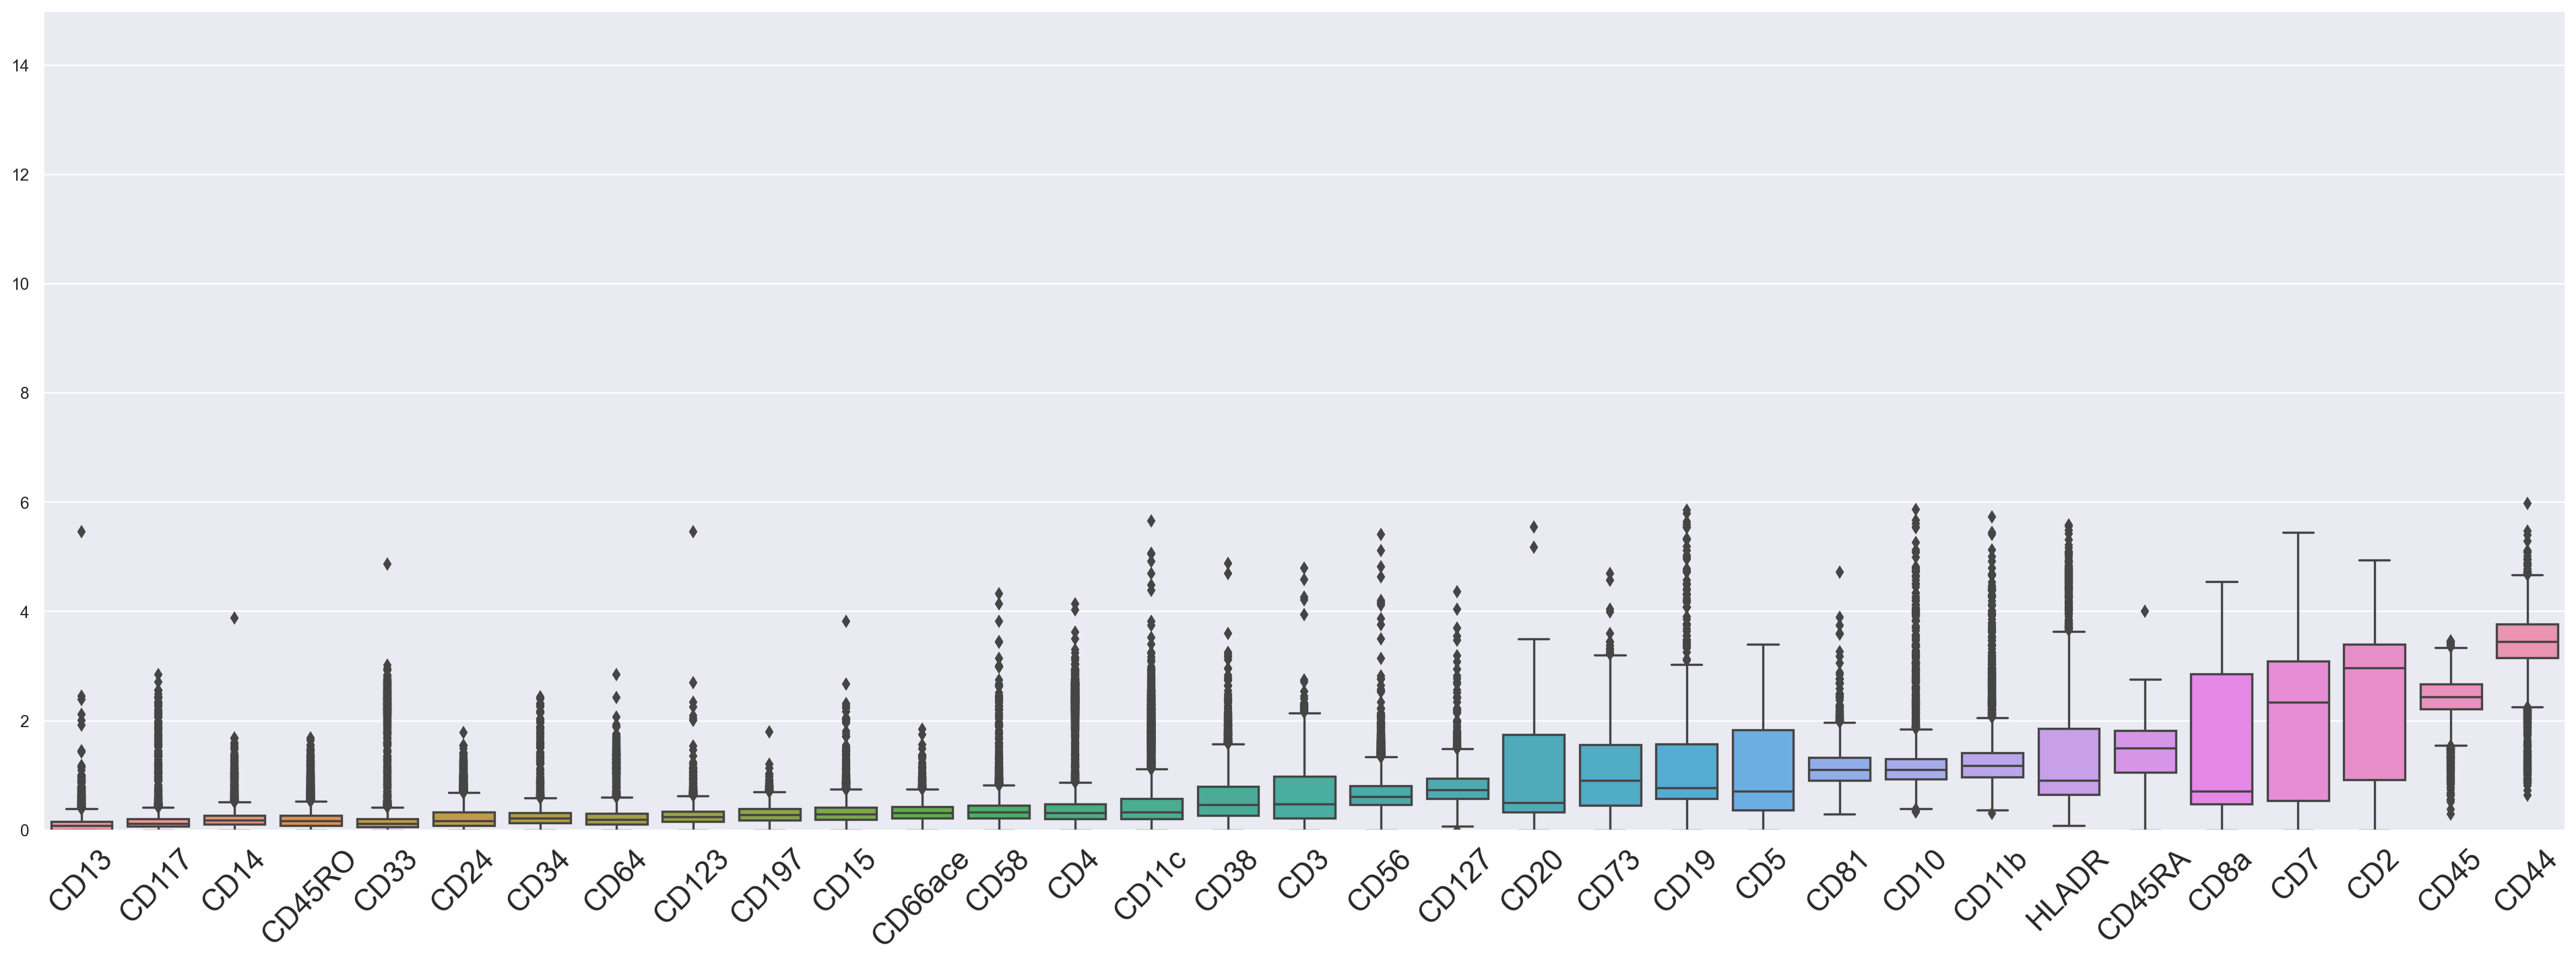

In [27]:
plt.figure(figsize=(30,10))
plt.ylim(0, 15)
g=sns.boxplot(data=df_sorted2)


g.set_xticklabels(g.get_xticklabels(),rotation=45) #rotation

g.tick_params(axis='x', labelsize=20) #increased font

<AxesSubplot: xlabel='CD56', ylabel='Density'>

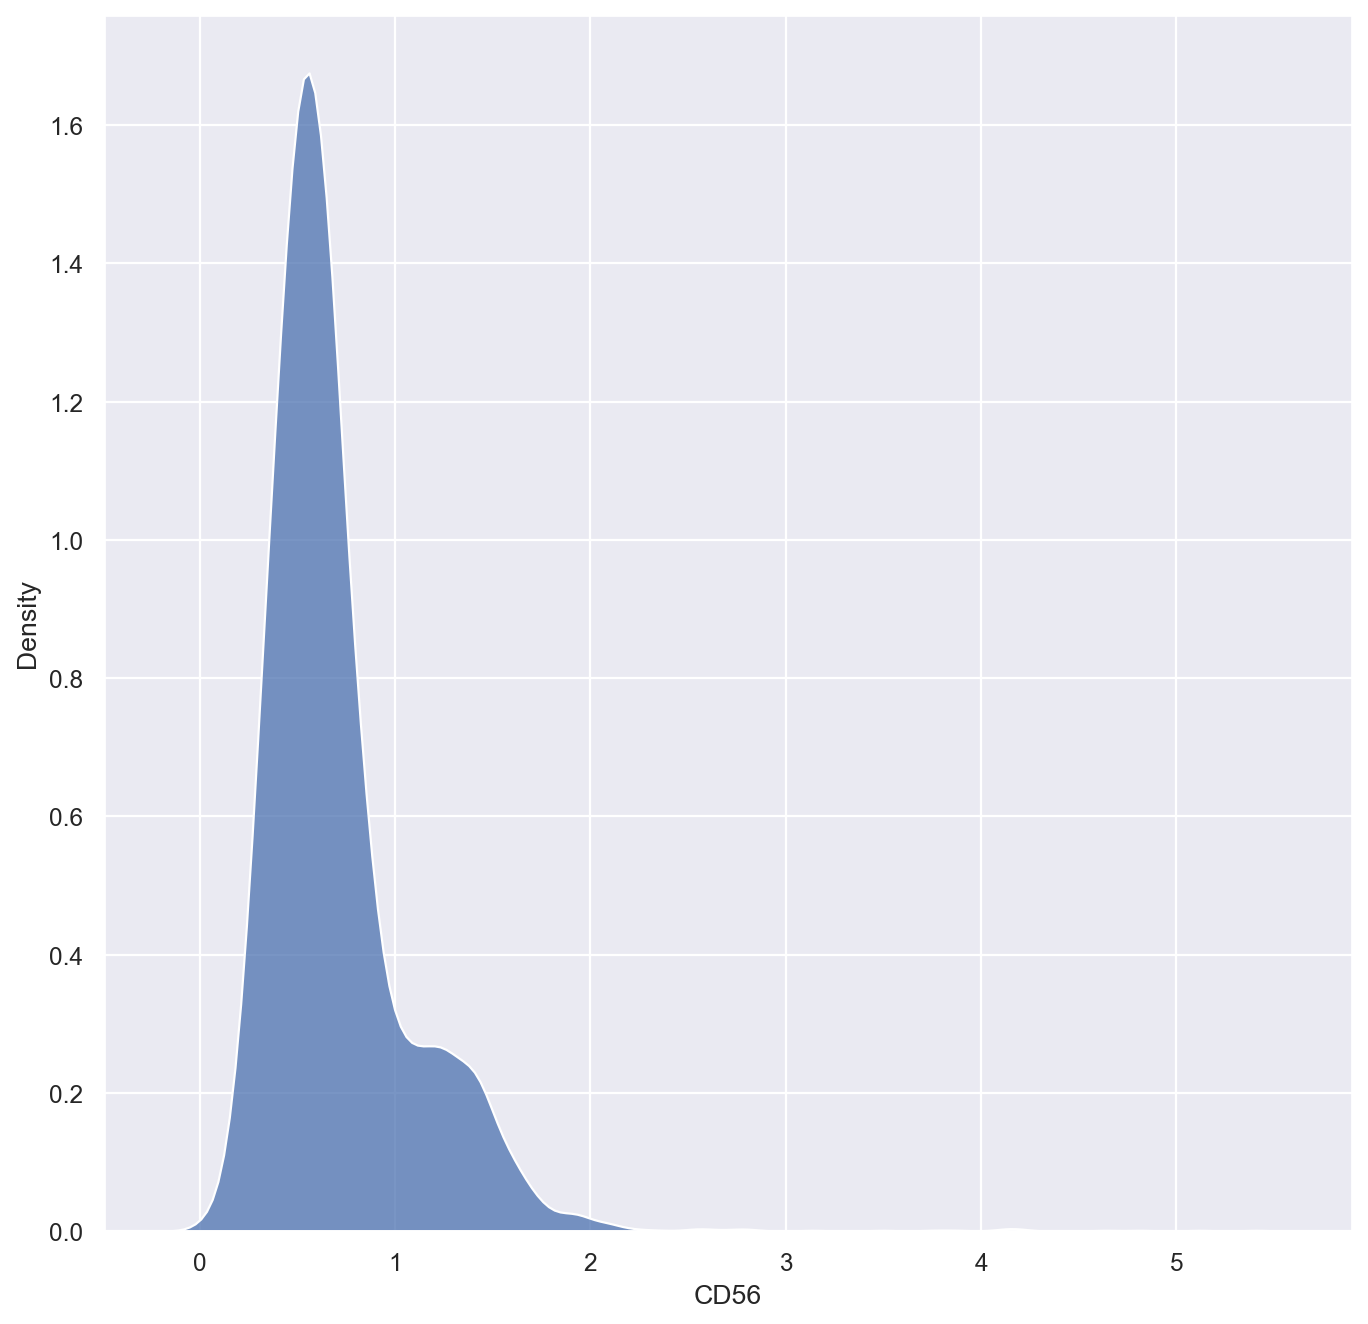

In [13]:
sns.kdeplot(data=prot_CLR_norm, x="CD56", multiple="stack")

<Figure size 800x800 with 0 Axes>

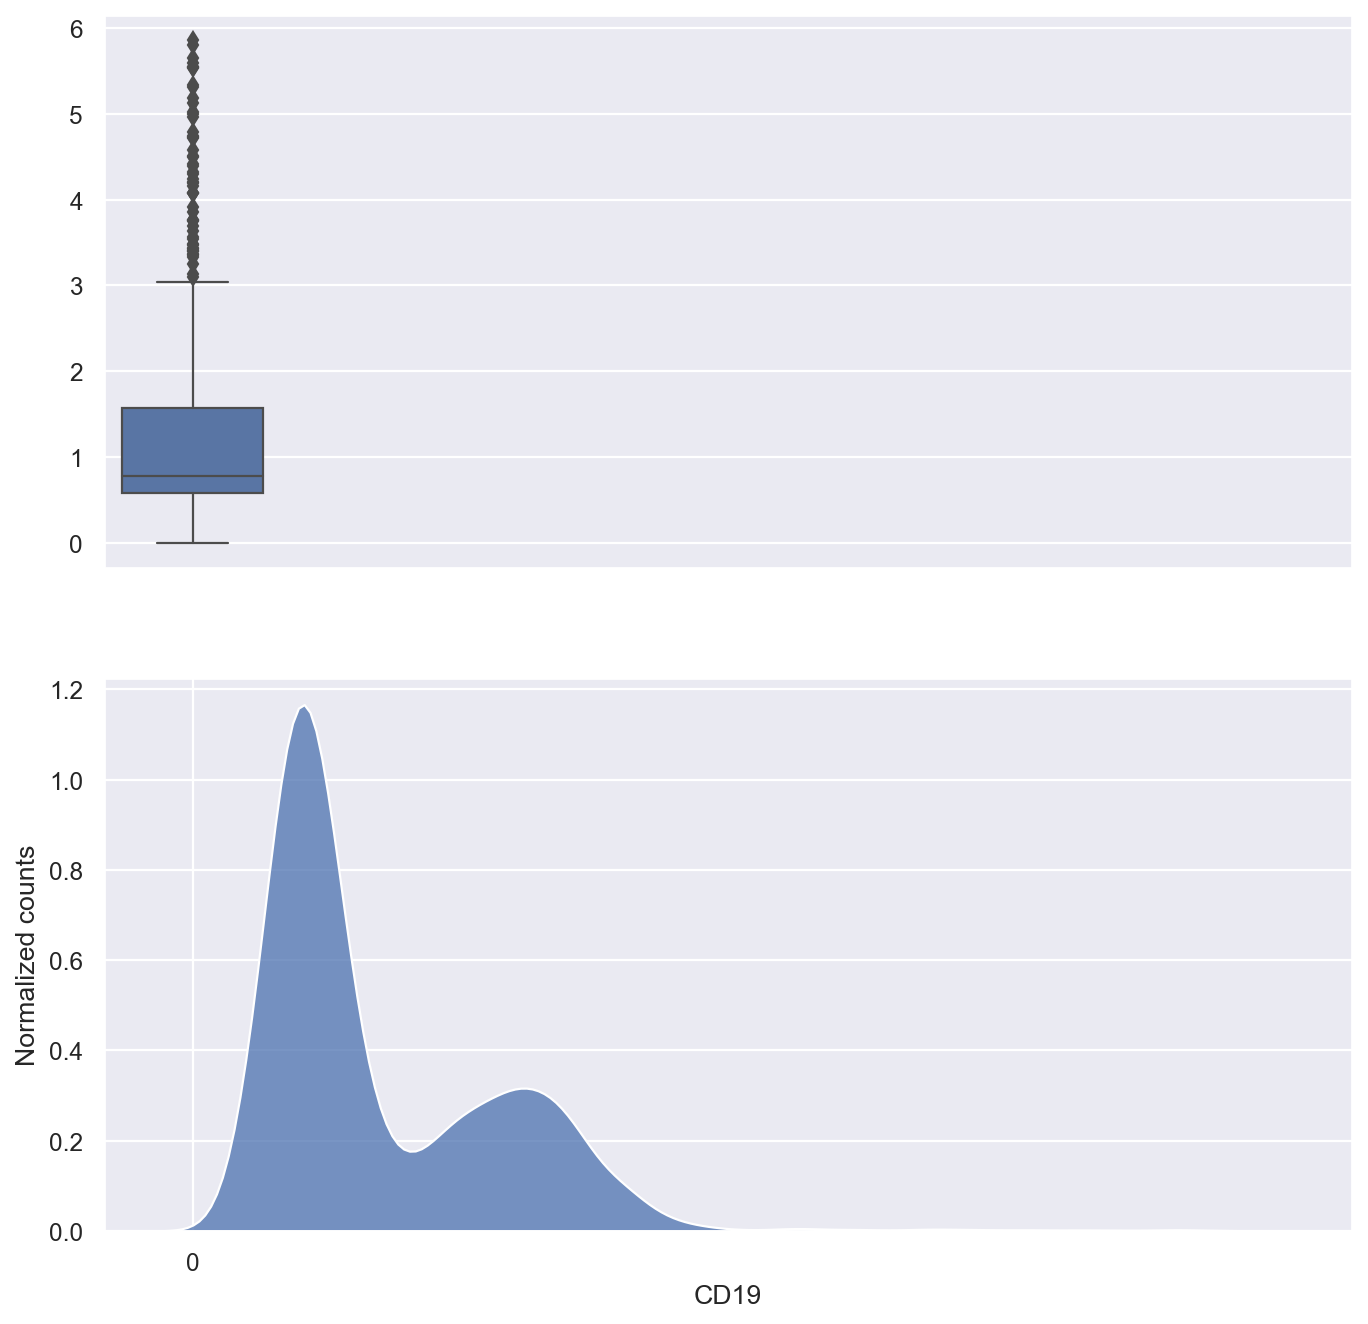

<Figure size 800x800 with 0 Axes>

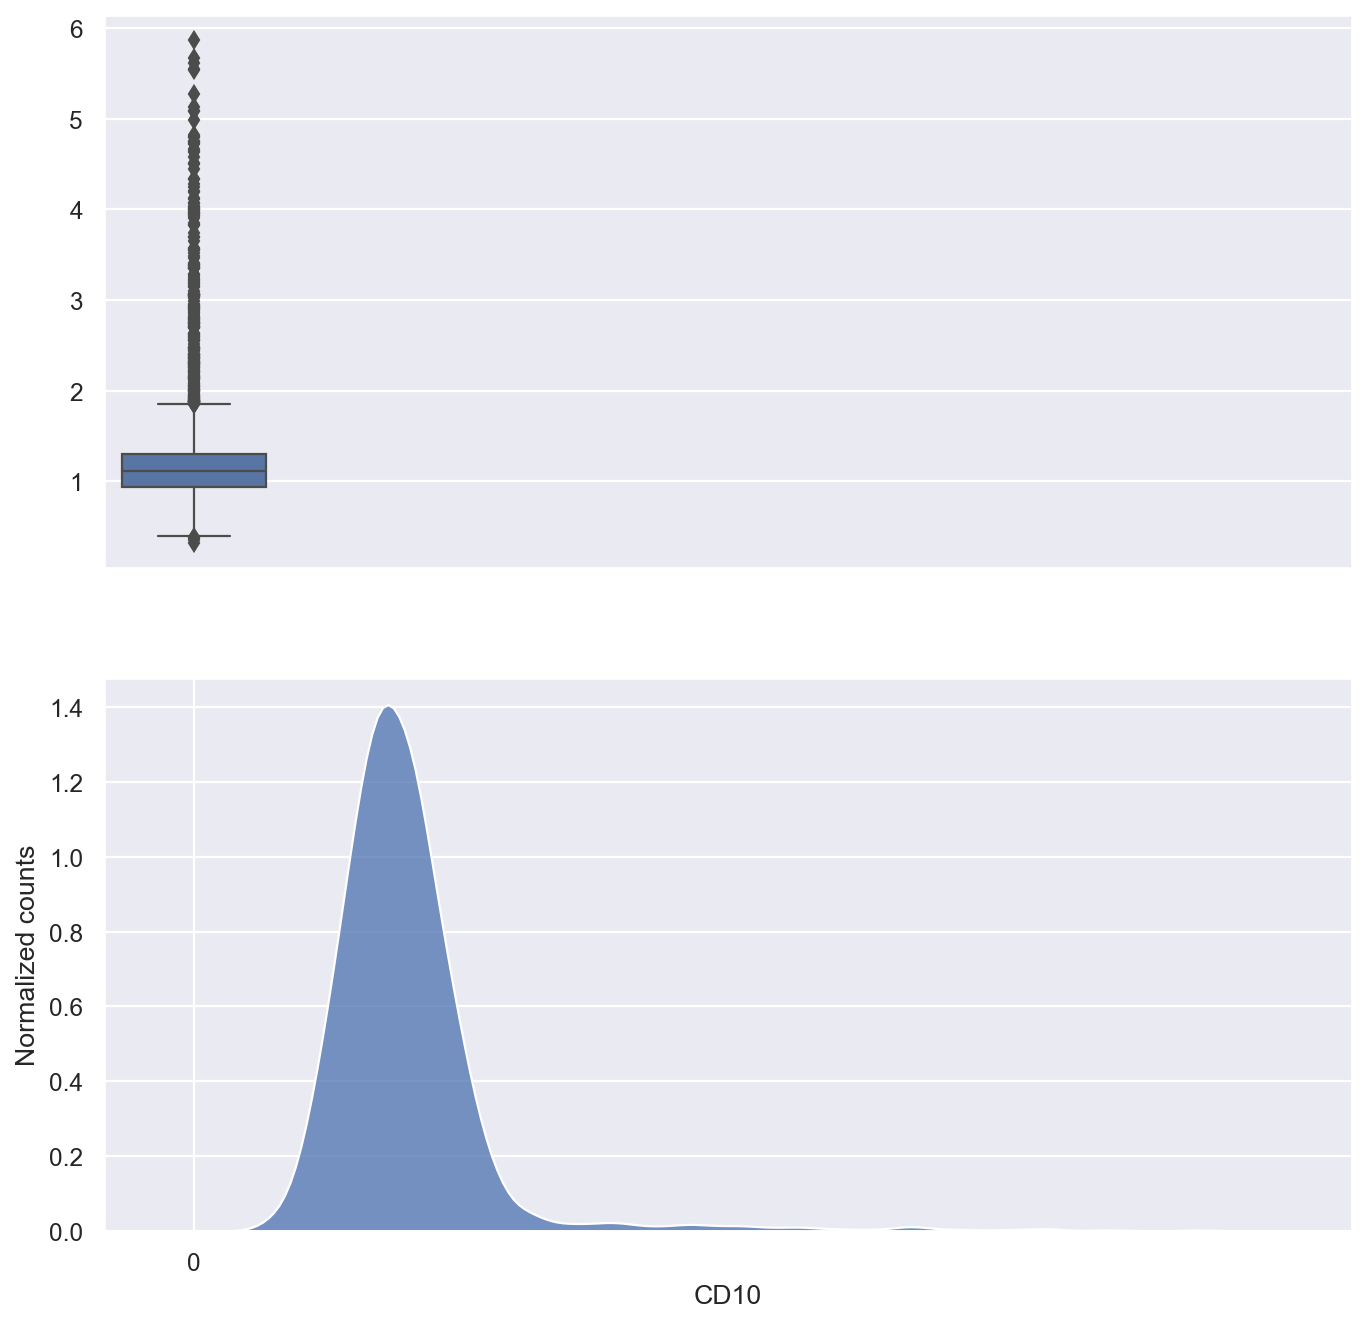

In [14]:
for i in prot_CLR_norm.columns[1:3]:
    plt.figure()
    plt.tight_layout()
    sns.set(rc={"figure.figsize":(10, 10)})
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True)
    plt.gca().set(xlabel= i,ylabel='Normalized counts')
    sns.boxplot(prot_CLR_norm[i], ax=ax_box , linewidth= 1.0)
    sns.kdeplot(prot_CLR_norm[i], ax=ax_hist, multiple="stack")

## Comparisons of DSB and CLR

Text(0.5, 1.0, 'DSB normalized')

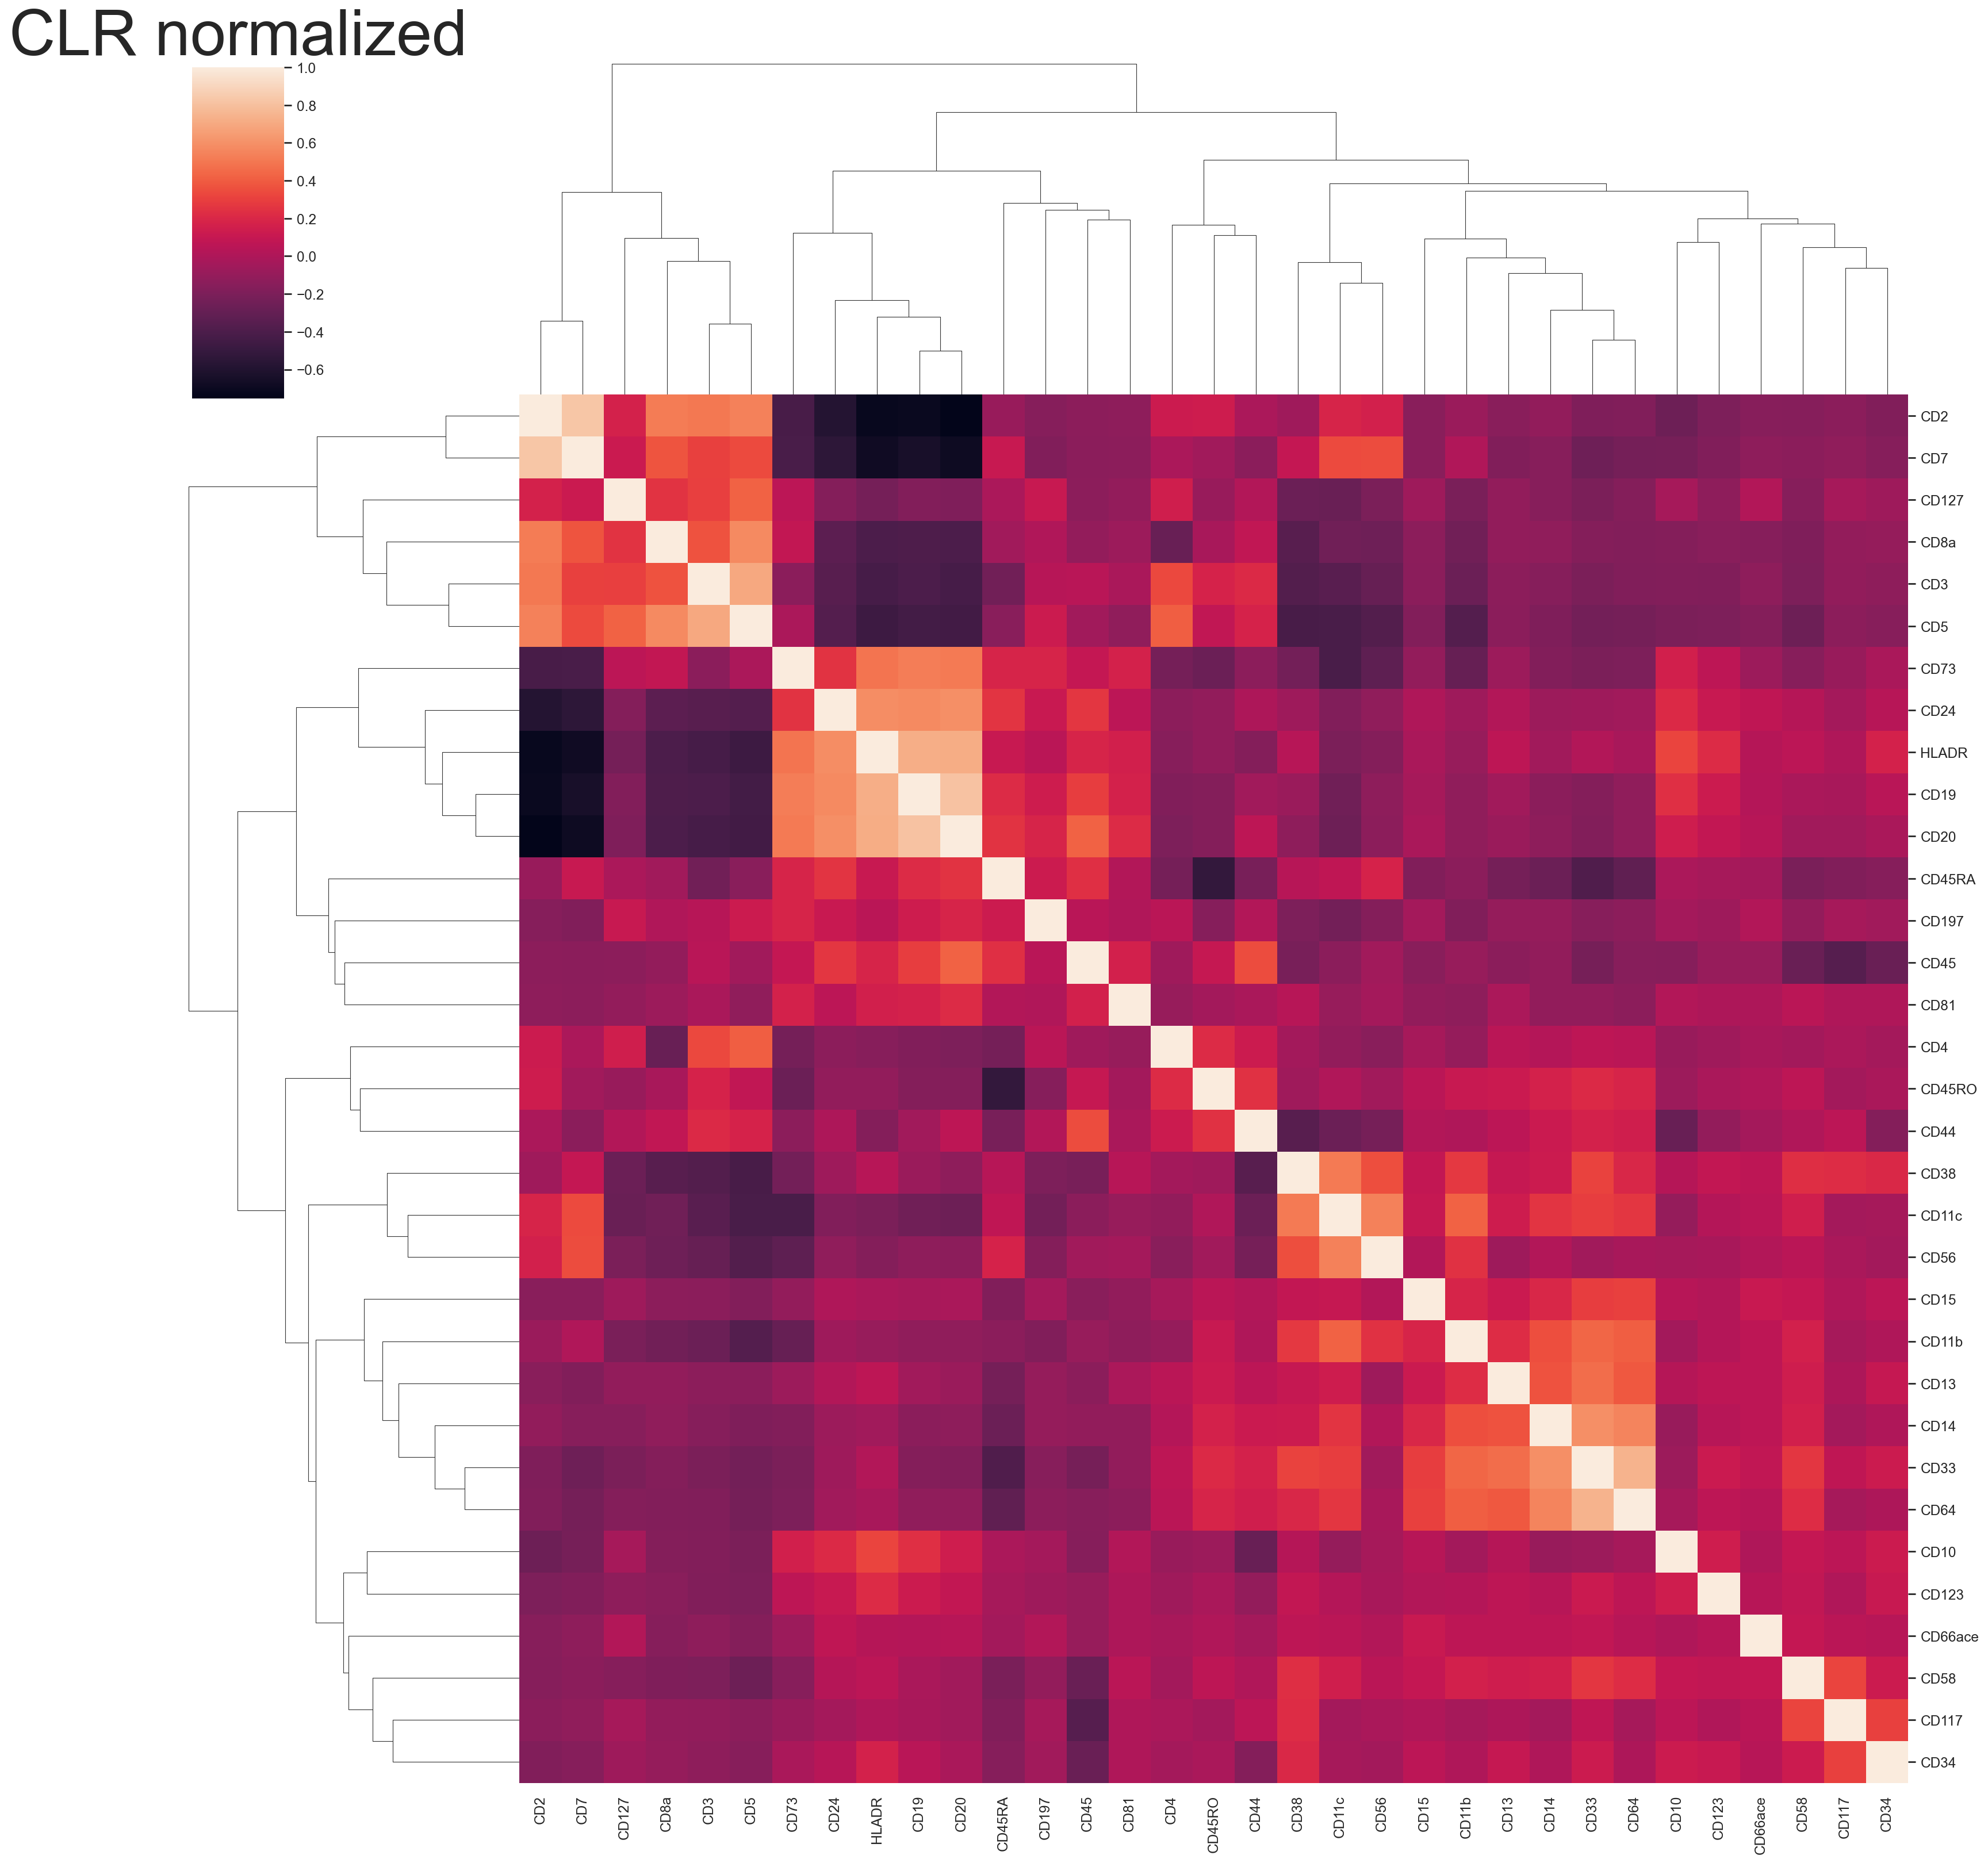

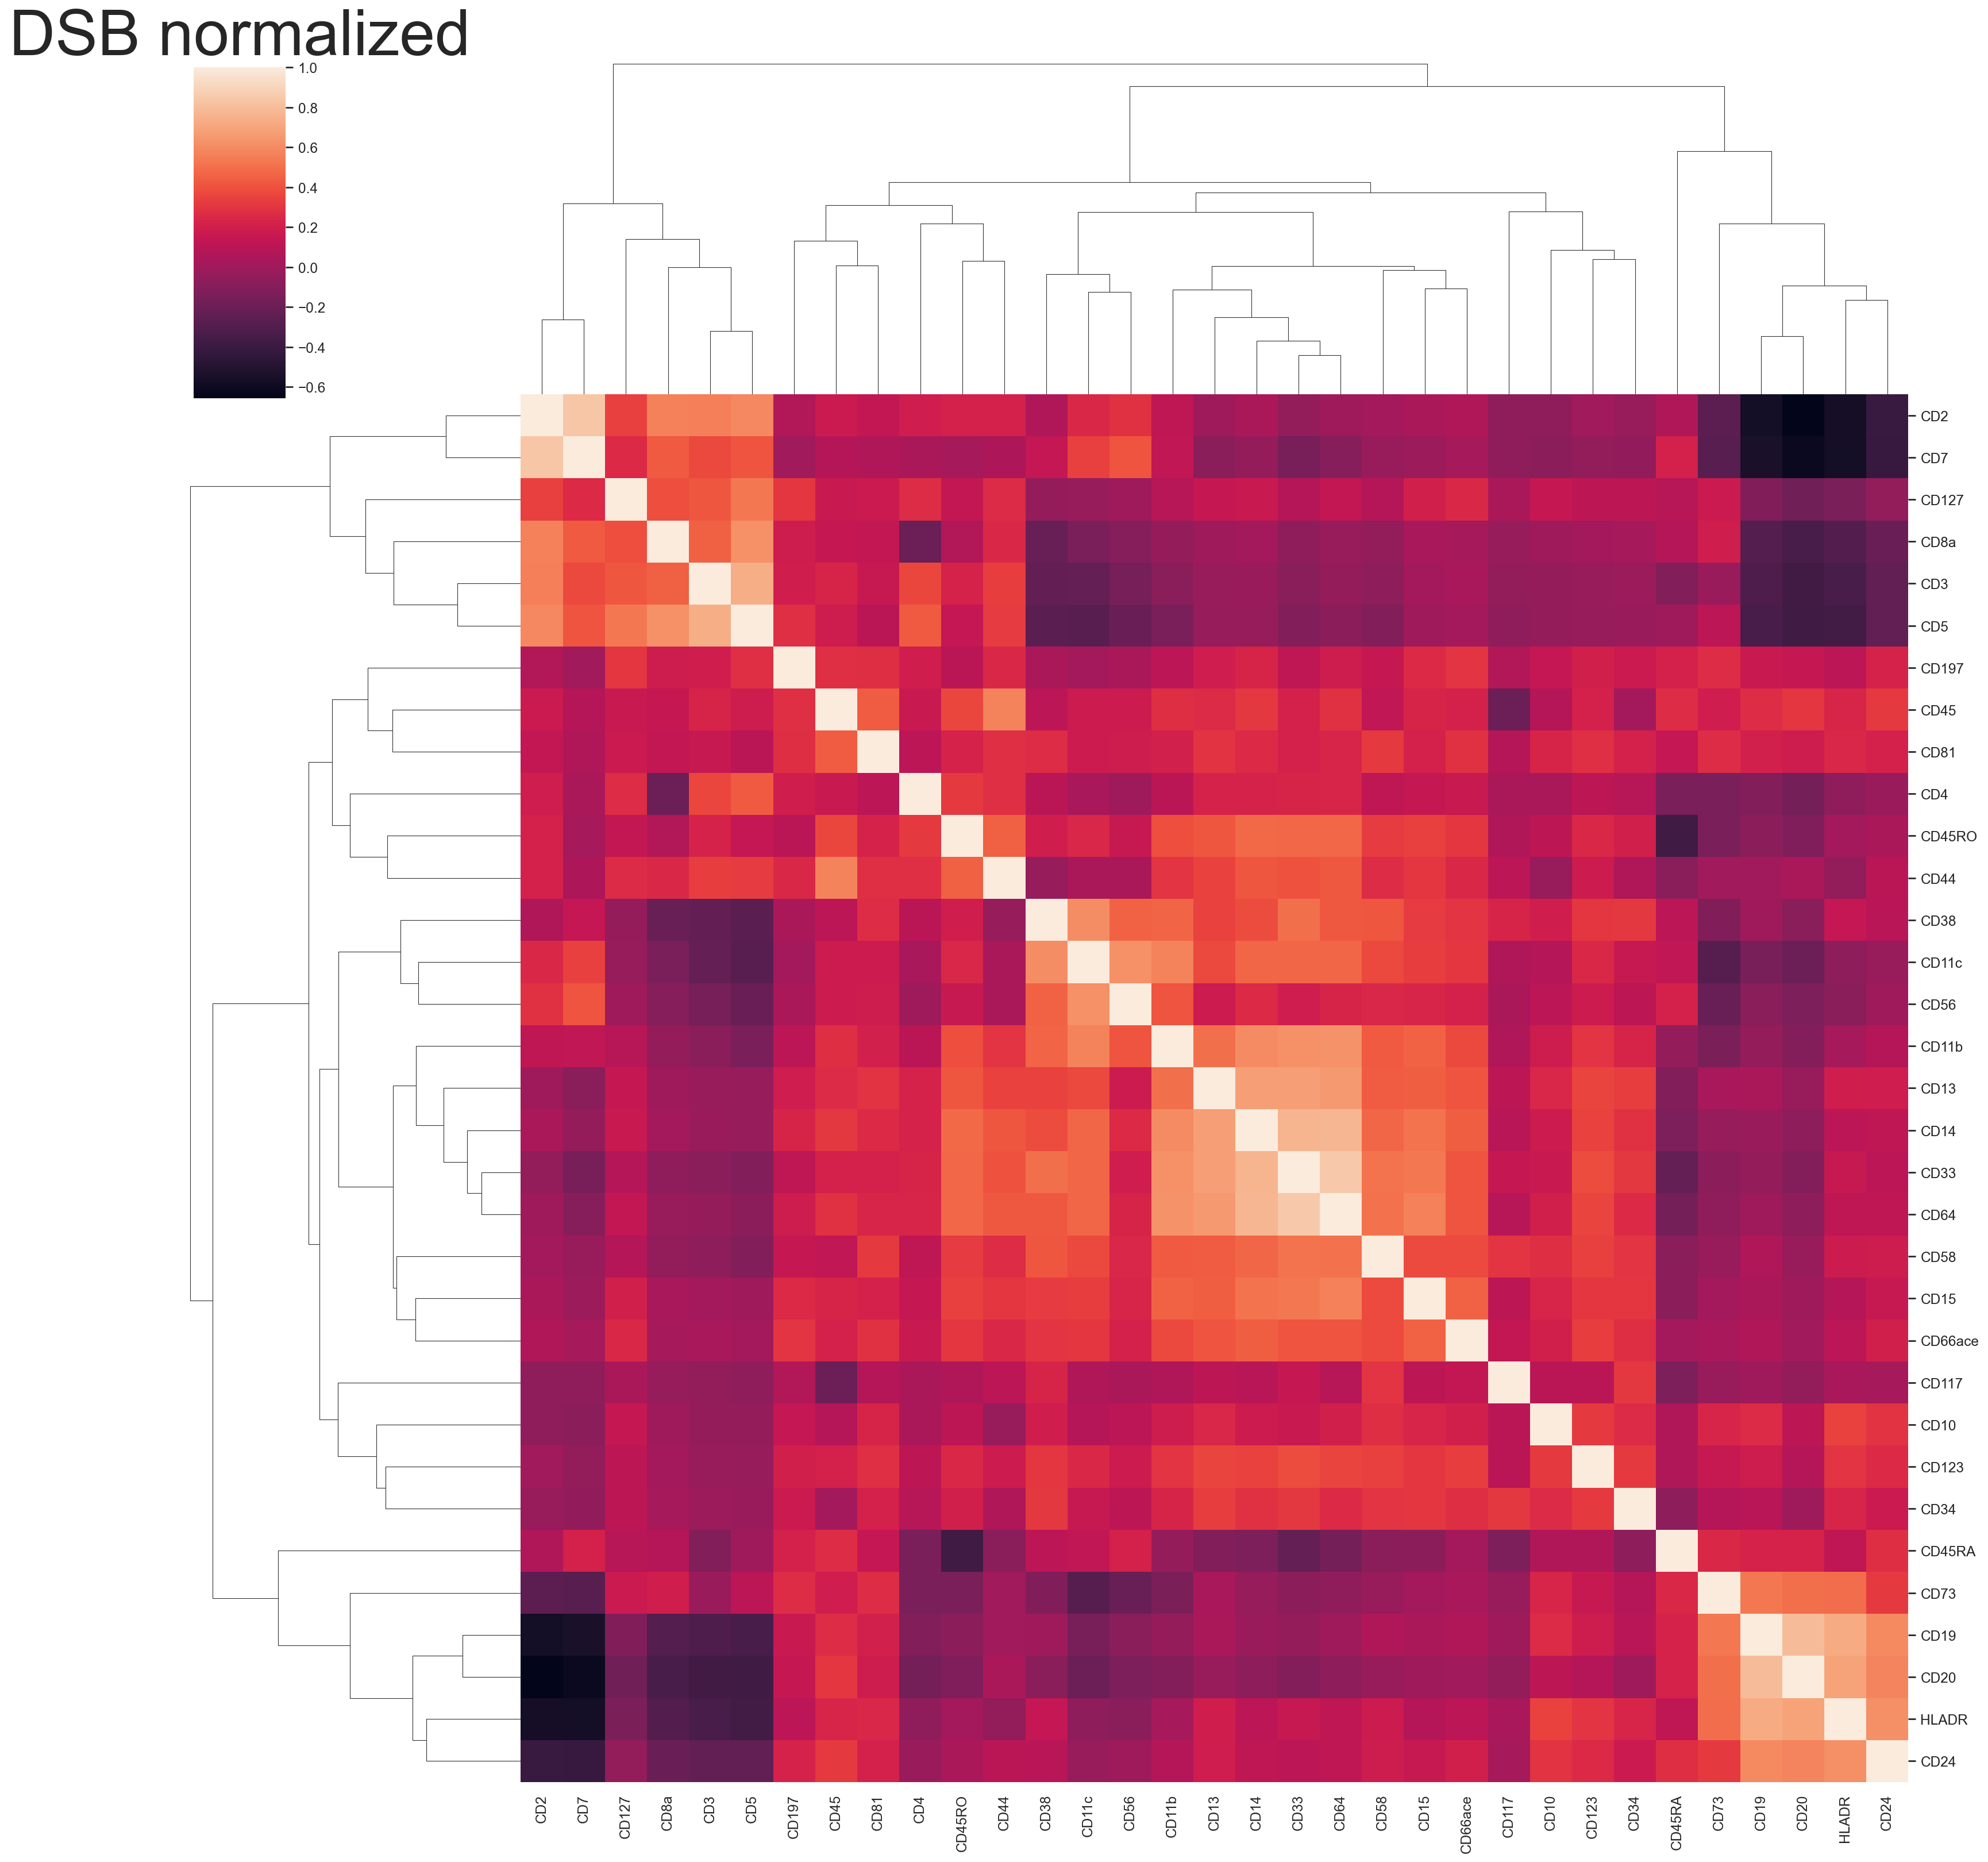

In [28]:
#CLR normalized 

matrix_prot2=prot_CLR_norm.corr(method='pearson', min_periods=1)

sns.clustermap(matrix_prot2, figsize=(20,20))

plt.title('CLR normalized', fontsize = 50)

#DSB normalized

sns.clustermap(matrix_prot, figsize=(20,20))

plt.title('DSB normalized', fontsize = 50)

Text(0.5, 1.0, 'CLR normalized')

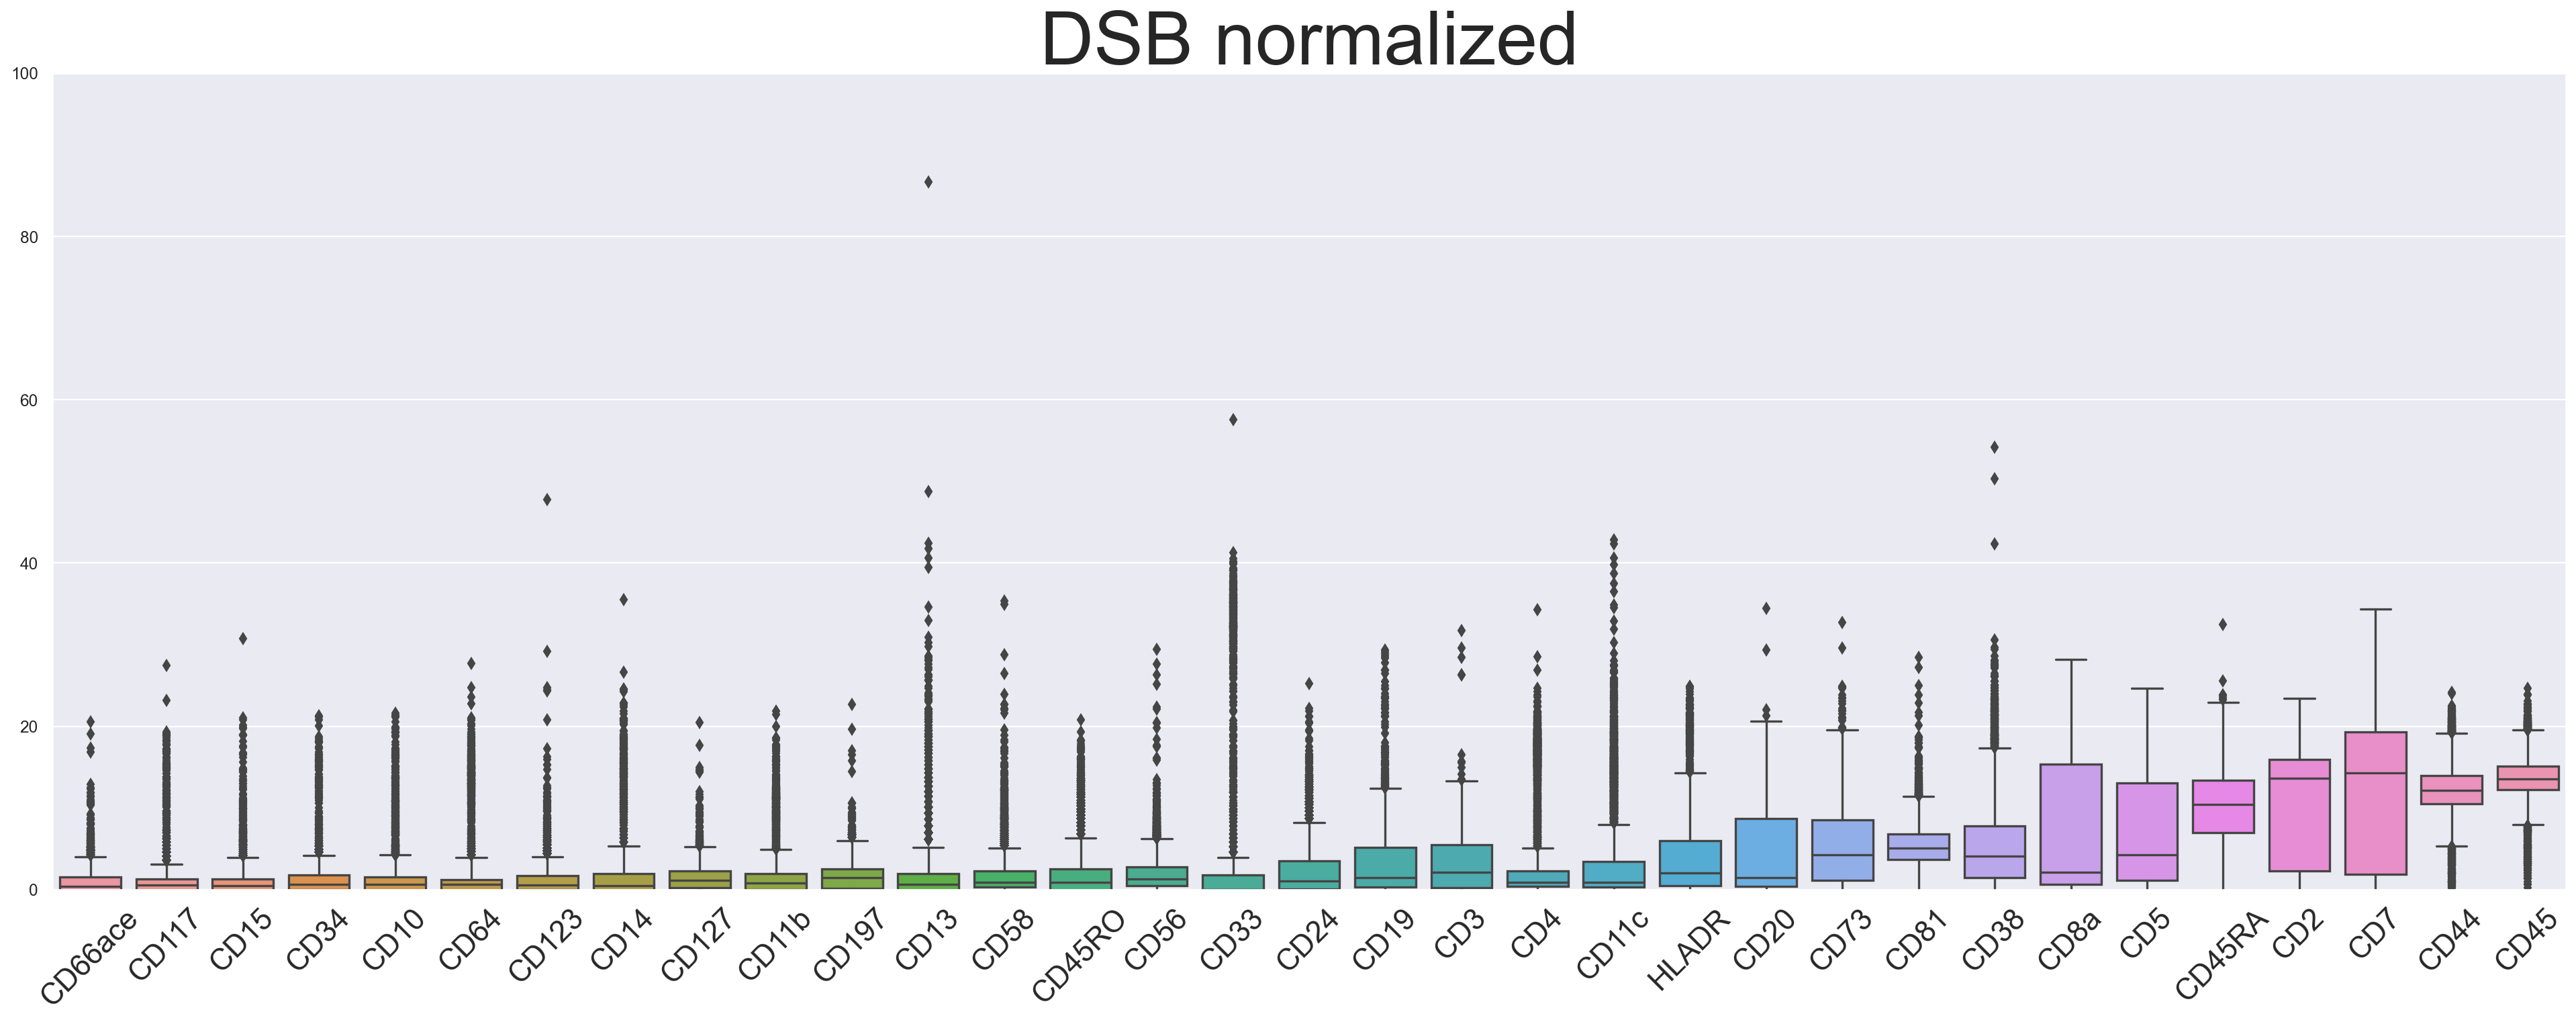

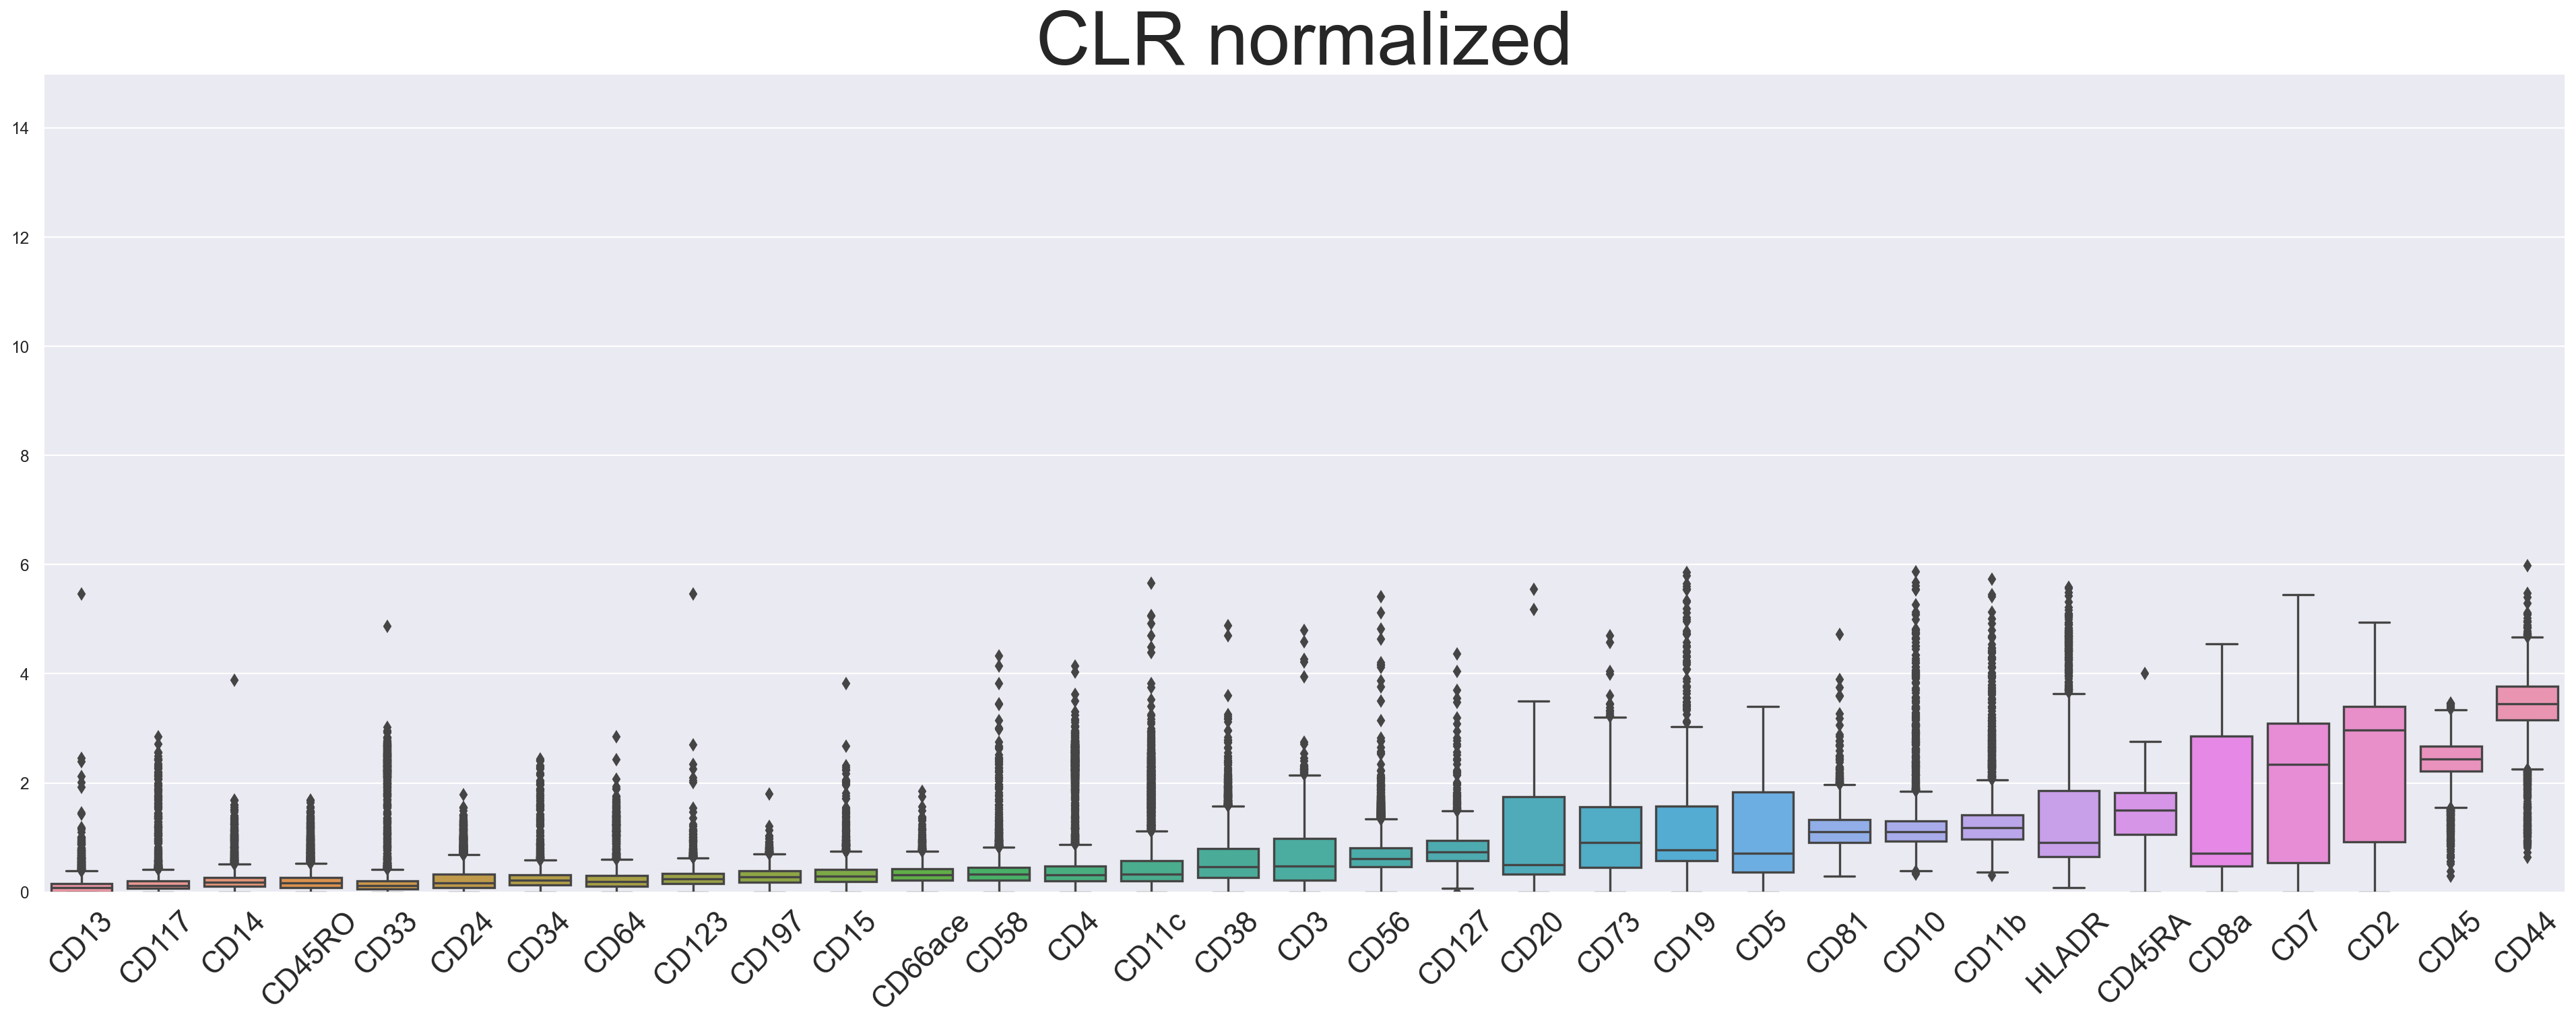

In [29]:
#DSB normalized
plt.figure(figsize=(30,10))
plt.ylim(0, 100)
d=sns.boxplot(data=df_sorted)

d.set_xticklabels(d.get_xticklabels(),rotation=45) #rotation
d.tick_params(axis='x', labelsize=20) #increased font
plt.title('DSB normalized', fontsize = 50)

#CLR normalized
plt.figure(figsize=(30,10))
plt.ylim(0, 15)
g=sns.boxplot(data=df_sorted2)


g.set_xticklabels(g.get_xticklabels(),rotation=45) #rotation
g.tick_params(axis='x', labelsize=20) #increased font
plt.title('CLR normalized', fontsize = 50)

In [30]:
c= prot_norm 
d= prot_CLR_norm

df_c = pd.DataFrame(data=c)
df_c['Normalization']="DSB"
df_c

df_d = pd.DataFrame(data=d)
df_d['Normalization']="CLR"
df_d



,Unnamed: 0,CD19,CD10,CD20,CD3,CD2,CD11b,HLADR,CD38,CD11c,...,CD15,CD64,CD117,CD24,CD44,CD58,CD66ace,CD13,CD34,Normalization
0,AAACCTGAGATCGGGT-1,0.312278,0.872477,0.257141,0.902653,3.445184,0.741748,0.741748,0.312278,0.257141,...,0.257141,0.198786,0.257141,0.070744,3.076046,0.364533,0.257141,0.136813,0.136813,CLR
1,AAACCTGAGCTGCCCA-1,0.789722,0.908400,0.655040,0.380222,2.736535,1.465750,0.830867,1.759777,2.309277,...,0.380222,0.088489,0.088489,0.088489,2.674714,0.314875,0.169780,0.000000,0.169780,CLR
2,AAACCTGAGTCAAGGC-1,0.763791,0.798779,0.377449,1.214682,3.350379,0.763791,0.428521,0.266744,0.142240,...,0.142240,0.073647,0.000000,0.206428,3.459463,0.266744,0.323628,0.073647,0.206428,CLR
3,AAACCTGCAAGGTTTC-1,0.541050,0.938152,0.391055,0.113003,2.909471,1.256281,0.468863,0.730788,1.322184,...,0.306679,0.214523,0.214523,0.214523,3.438751,0.214523,0.214523,0.113003,0.000000,CLR
4,AAACCTGCAGACGCAA-1,0.755476,1.024961,0.447446,0.172359,3.203033,1.151583,0.710285,1.690177,0.879950,...,0.319332,0.000000,0.319332,0.089888,2.937567,0.248543,0.613274,0.319332,0.089888,CLR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6257,TTTGTCAGTTGGGACA-1,0.379834,0.706439,0.344089,0.186772,1.467177,2.496535,1.932083,0.802949,0.680783,...,0.479989,1.557656,0.000000,0.143246,4.263033,0.779680,0.379834,0.344089,0.143246,CLR
6258,TTTGTCATCGCCATAA-1,0.515891,1.069139,0.202976,1.956733,4.121460,1.725155,0.753874,0.371624,0.202976,...,0.371624,0.290851,0.106629,0.000000,4.338788,0.641945,0.290851,0.202976,0.290851,CLR
6259,TTTGTCATCGGTTAAC-1,2.144289,1.078778,1.985128,0.294566,0.648908,1.039181,1.653399,0.376191,0.205682,...,0.521818,0.108120,0.000000,0.761653,3.637448,0.294566,0.521818,0.108120,0.205682,CLR
6260,TTTGTCATCGTCTGCT-1,1.455920,1.424767,2.466916,0.233549,0.718959,1.132883,2.310162,0.996942,0.505422,...,0.123577,0.000000,0.123577,0.422747,3.545975,0.000000,0.652721,0.123577,0.505422,CLR


In [31]:
df_normalized=pd.concat([df_c, df_d])
df_normalized

,Unnamed: 0,CD19,CD10,CD20,CD3,CD2,CD11b,HLADR,CD38,CD11c,...,CD15,CD64,CD117,CD24,CD44,CD58,CD66ace,CD13,CD34,Normalization
0,AAACCTGAGATCGGGT-1,-1.227712,-0.079973,-0.043934,5.104354,16.567026,-0.666104,1.325765,2.836796,0.876088,...,0.463894,0.603483,1.923302,0.051516,11.221979,1.834181,0.357217,1.919708,-0.026487,DSB
1,AAACCTGAGCTGCCCA-1,1.037210,-0.560365,2.097772,1.061533,11.757624,1.974177,1.134338,16.690966,16.274235,...,0.908526,-0.680680,-0.165842,0.051516,8.336772,0.862596,-0.613060,-0.735727,-0.026487,DSB
2,AAACCTGAGTCAAGGC-1,1.479029,-0.560365,0.757874,6.926298,15.868343,-0.666104,-0.482723,2.163235,-0.285708,...,-0.529547,-0.680680,-0.991498,1.901219,12.817587,0.862596,0.791482,0.652425,0.627242,DSB
3,AAACCTGCAAGGTTTC-1,-0.885738,-1.099720,-0.043934,-0.747464,11.405987,0.265327,-1.069650,5.144601,7.338481,...,-0.013703,-0.011814,0.587922,1.014948,10.723041,-0.259016,-0.613060,0.652425,-1.515554,DSB
4,AAACCTGCAGACGCAA-1,0.801671,-0.079973,0.757874,-0.239965,14.078522,0.536040,0.508169,15.870083,5.246038,...,0.463894,-1.413340,1.923302,0.051516,9.480280,0.323381,2.279395,4.164847,-0.737132,DSB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6257,TTTGTCAGTTGGGACA-1,0.379834,0.706439,0.344089,0.186772,1.467177,2.496535,1.932083,0.802949,0.680783,...,0.479989,1.557656,0.000000,0.143246,4.263033,0.779680,0.379834,0.344089,0.143246,CLR
6258,TTTGTCATCGCCATAA-1,0.515891,1.069139,0.202976,1.956733,4.121460,1.725155,0.753874,0.371624,0.202976,...,0.371624,0.290851,0.106629,0.000000,4.338788,0.641945,0.290851,0.202976,0.290851,CLR
6259,TTTGTCATCGGTTAAC-1,2.144289,1.078778,1.985128,0.294566,0.648908,1.039181,1.653399,0.376191,0.205682,...,0.521818,0.108120,0.000000,0.761653,3.637448,0.294566,0.521818,0.108120,0.205682,CLR
6260,TTTGTCATCGTCTGCT-1,1.455920,1.424767,2.466916,0.233549,0.718959,1.132883,2.310162,0.996942,0.505422,...,0.123577,0.000000,0.123577,0.422747,3.545975,0.000000,0.652721,0.123577,0.505422,CLR


<AxesSubplot: xlabel='CD56', ylabel='Density'>

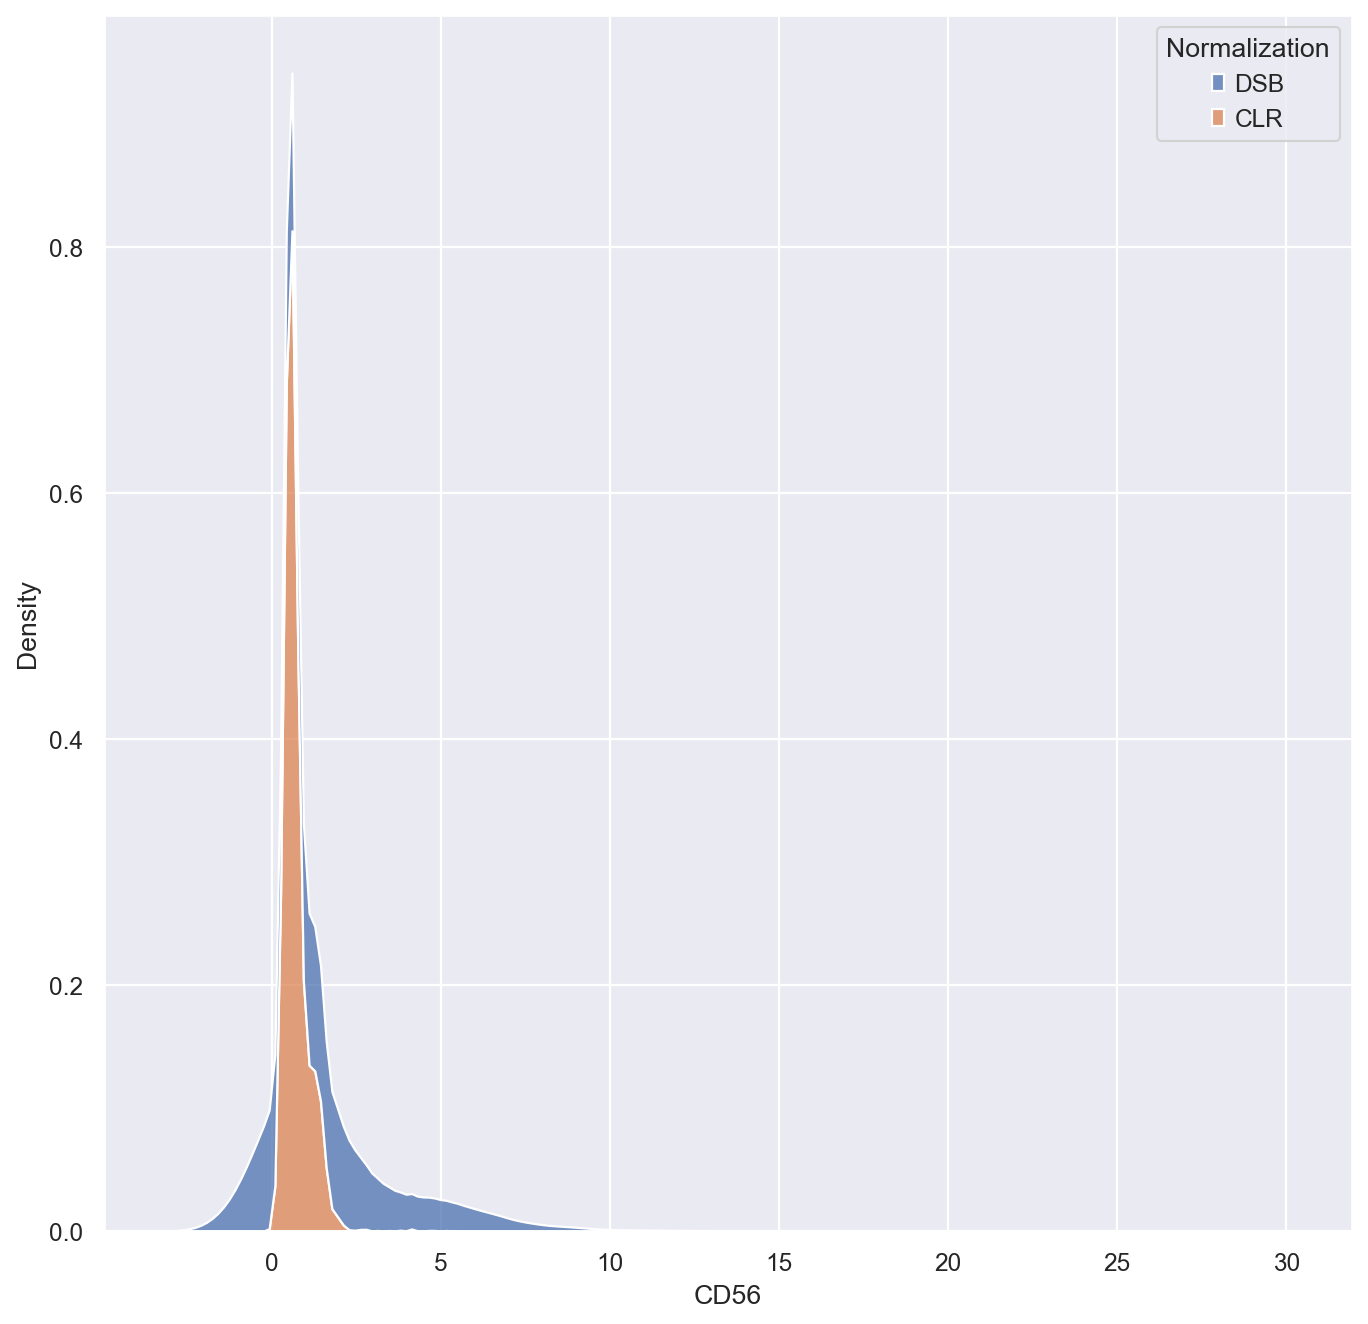

In [32]:
sns.kdeplot(data=df_normalized, x="CD56", hue="Normalization", multiple="stack")

<AxesSubplot: xlabel='CD3', ylabel='Density'>

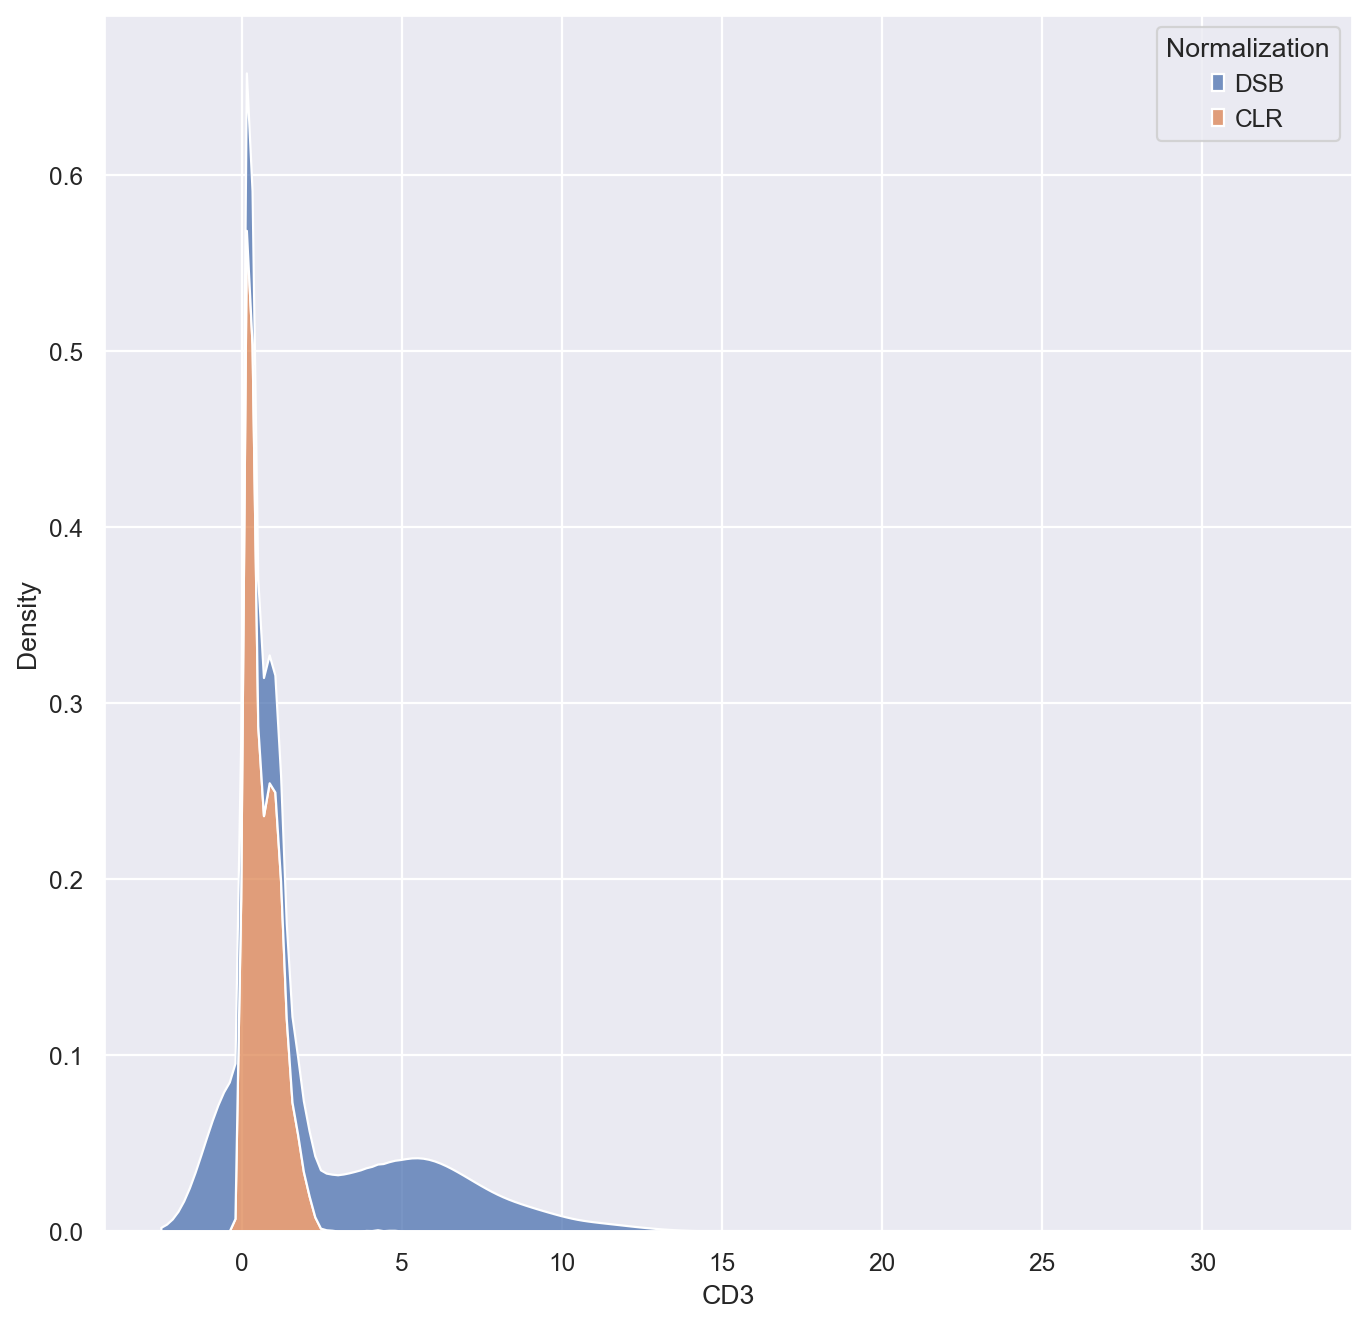

In [20]:
sns.kdeplot(data=df_normalized, x="CD3", hue="Normalization", multiple="stack")

<AxesSubplot: xlabel='CD56', ylabel='Normalization'>

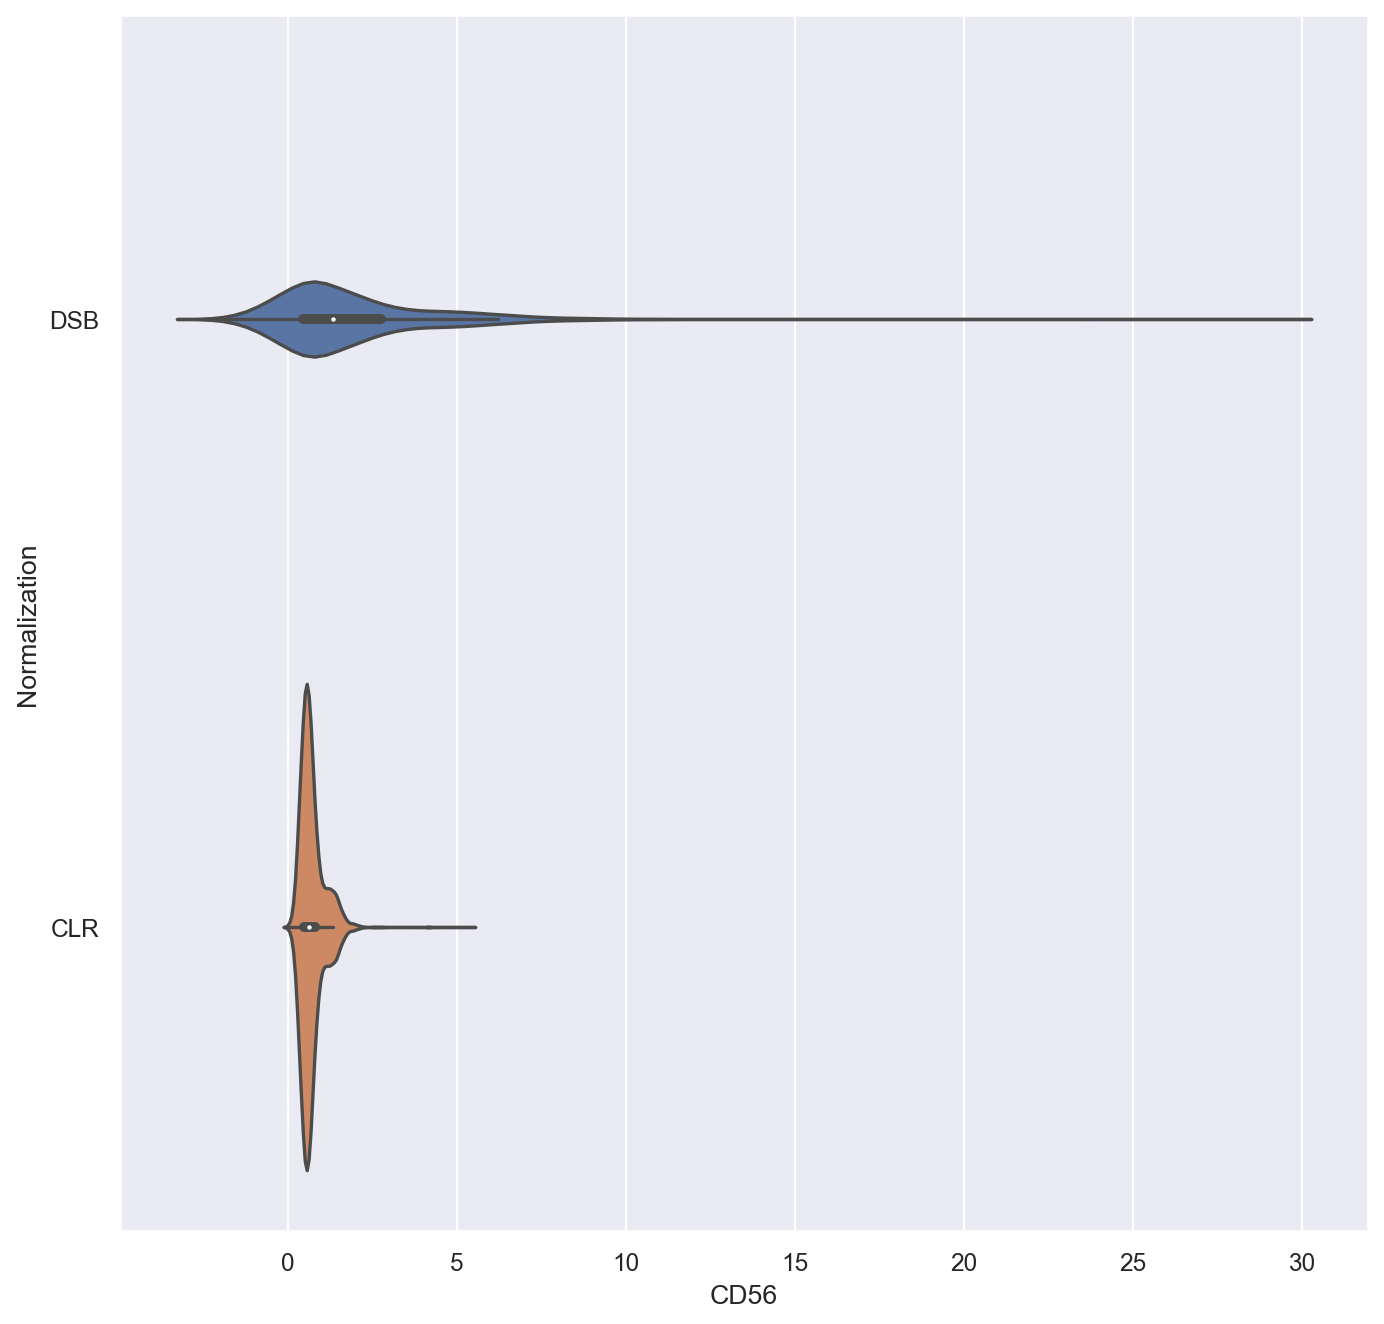

In [21]:
sns.violinplot(data=df_normalized, x="CD56", y="Normalization")

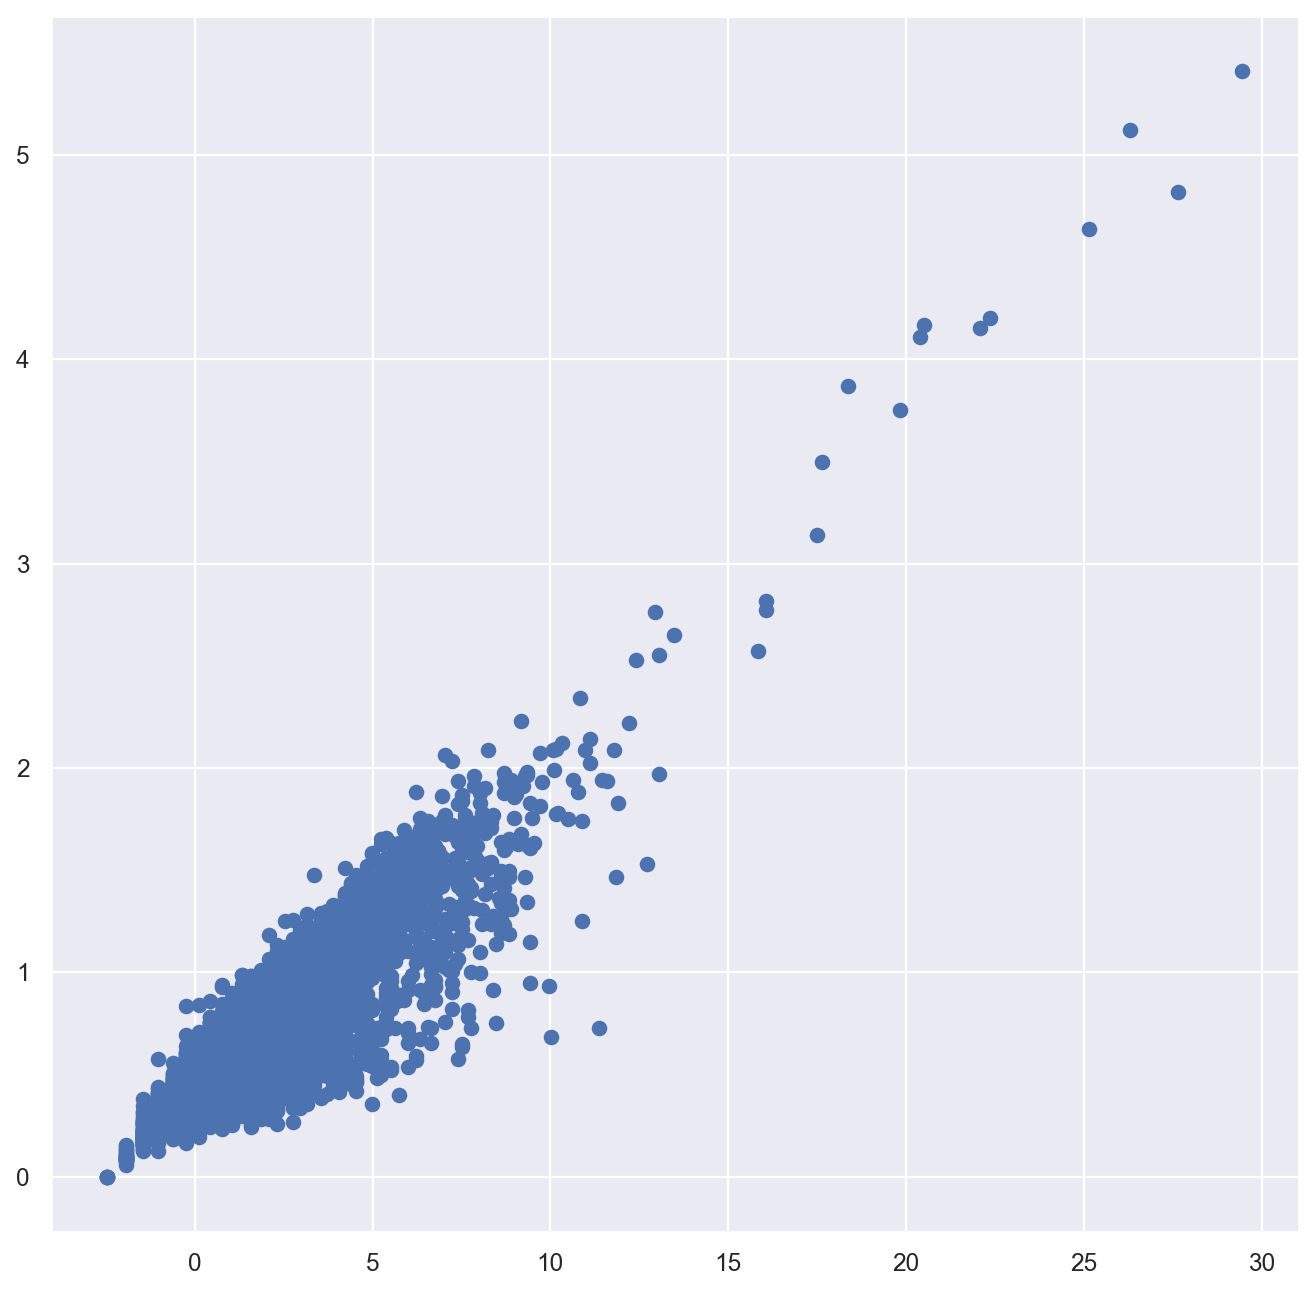

In [22]:
plt.scatter(df_c['CD56'], df_d['CD56'])

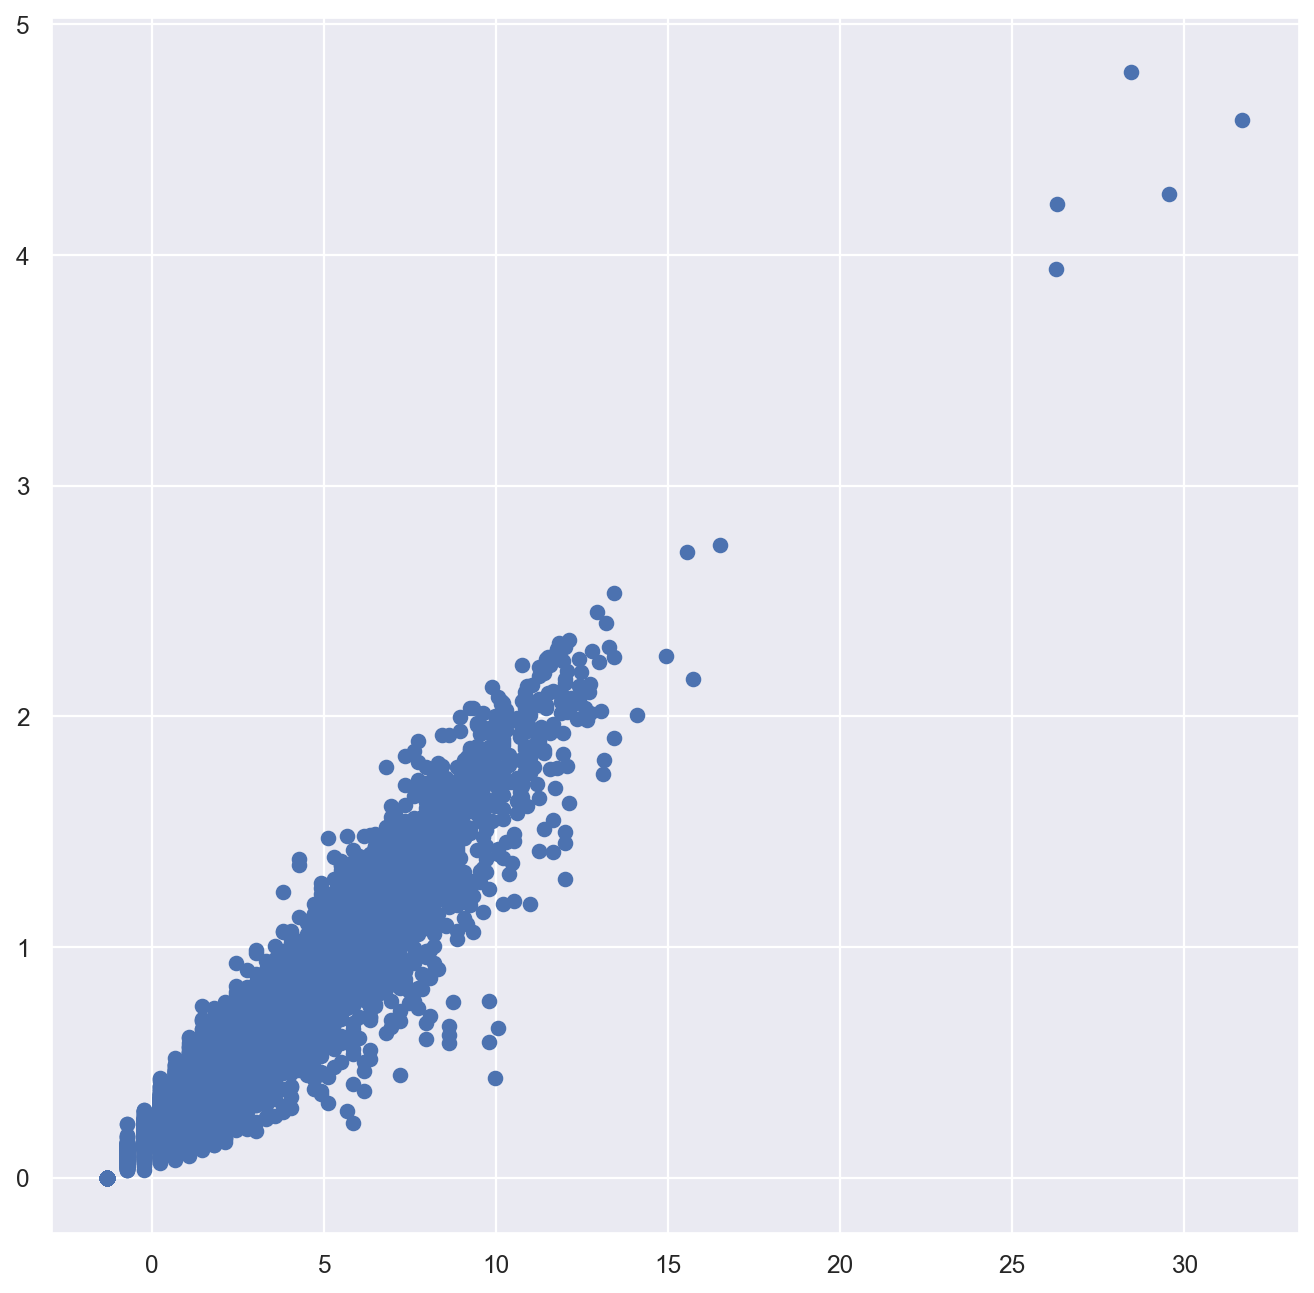

In [23]:
plt.scatter(df_c['CD3'], df_d['CD3'])

Text(0.5, 0.98, 'CD3')

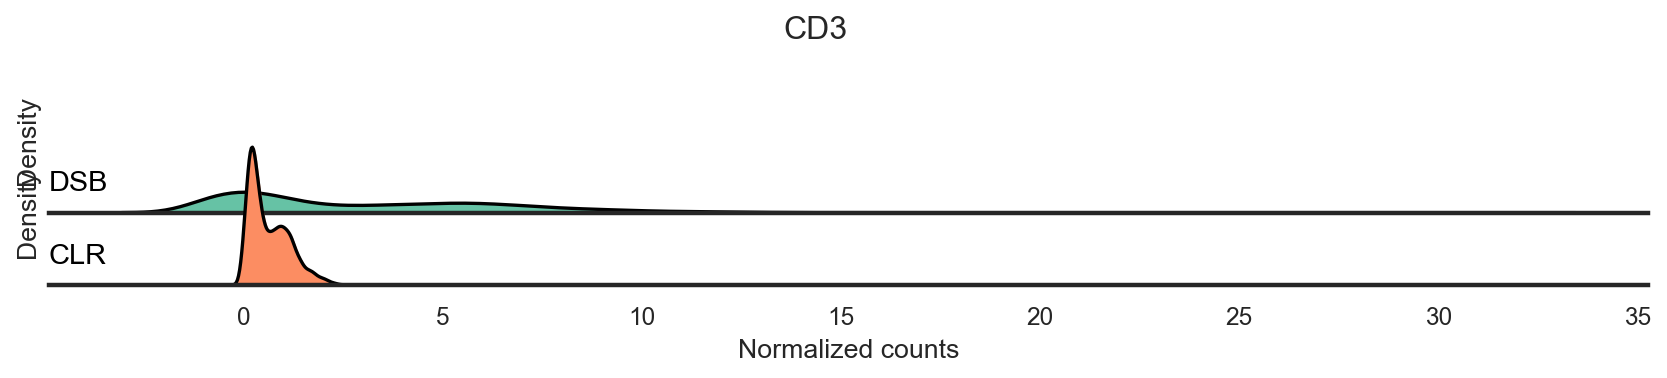

In [24]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
palette = sns.color_palette("Set2", 12)

g = sns.FacetGrid(df_normalized, palette=palette, row="Normalization", hue="Normalization", aspect=9, height=1.2)
g.map_dataframe(sns.kdeplot, x="CD3", fill=True, alpha=1)
g.map_dataframe(sns.kdeplot, x="CD3", color='black')

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "Normalization")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], xlabel="Normalized counts")
g.despine( left=True)

plt.suptitle('CD3', y=0.98)

Text(0.5, 0.98, 'CD19')

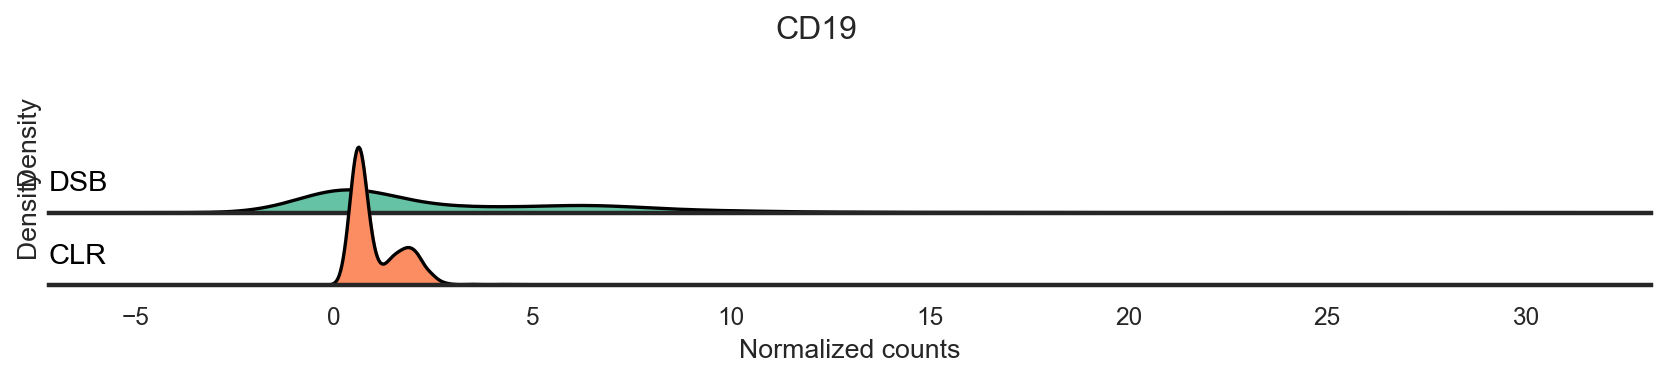

In [25]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
palette = sns.color_palette("Set2", 12)

g = sns.FacetGrid(df_normalized, palette=palette, row="Normalization", hue="Normalization", aspect=9, height=1.2)
g.map_dataframe(sns.kdeplot, x="CD19", fill=True, alpha=1)
g.map_dataframe(sns.kdeplot, x="CD19", color='black')

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "Normalization")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], xlabel="Normalized counts")
g.despine( left=True)

plt.suptitle('CD19', y=0.98)